In [1]:
'''
author: Yike Xie
data: 28/2/2023
content: correlate optical features and transcriptome
'''

'\nauthor: Yike Xie\ndata: 28/2/2023\ncontent: correlate optical features and transcriptome\n'

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

In [3]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    features.set_index('image', inplace=True)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)
    
    print('filter single cells')
    adata = adata[adata.obs['doublets'] != 'Yes']

#     print('filter genes')
#     sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

def get_correlation(adata_s, feas):
    #corr = dsim.correlation.correlate_features_phenotypes(feas, fillna=0)##
    exp = adata_s.X.T
    phe = adata_s.obs[feas].fillna(0)

    x = exp #(39466, 10)
    y = phe.values.T #(2, 10)

    from scipy.stats import rankdata

    xw = np.zeros_like(x, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')
    yw = np.zeros_like(y, float)
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                    data=r,
                    index=adata_s.var_names,
                    columns=phe.columns,
                    dtype=float)

    return corr

def plot_correlation(genes, adata_s, fea, xlabel, path, filetype=False):
    '''
    genes = {
    'positive': [],
    'negative': []
    }
    '''
    import itertools
    n_genes = len(list(itertools.chain.from_iterable(genes.values())))
    colors = sns.color_palette('tab10', n_genes)
    colors = [colors[: len(genes['positive'])], colors[len(genes['positive']):]]

    fig, axs = plt.subplots(2, 1, figsize=(4, 6), dpi=300)
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    for j, (ax, genes) in enumerate(zip(axs, [genes['positive'], genes['negative']])):
        for ig, gene in enumerate(genes):
            x = adata_s.obs[fea]
            y = adata_s[:, gene].X + 0.1
            idx = np.argsort(x)
            ax.scatter(
                x[idx], y[idx], alpha=0.8, label=gene, lw=2, color=colors[j][ig], s=10, 
            )
        ax.legend(fontsize=8, bbox_to_anchor=(1, 1))
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Gene exp [cpm]')
        ax.set_yscale('log')
#         ax.set_xscale('log')
        
    axs[0].set_title('Positive correlation')
    axs[1].set_title('Negative correlation')
    fig.tight_layout()

    if filetype is not False:
        plt.savefig(save_figures + fea + filetype)
    
    return {'fig': fig, 'axs': axs}

def plot_bins(adata, fea, bin_n, gene, cmap, filetype, path=False):
    area_order = adata.obs[fea].sort_values().index
    exp = adata[area_order, gene].X
    exp = pd.DataFrame(exp[:,0], index=area_order, columns=['Gene exp [cpm]'])

    exp['order'] = '0'
    for i in range(bin_n):
        n = round(exp.shape[0] / bin_n)
        idx = [j for j in np.arange(n) + n * i if j < exp.shape[0]]
        exp.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    fig, ax = plt.subplots(figsize=[2, 3])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    med = [exp[exp['order'] == 'Group {}'.format(str(i + 1))]['Gene exp [cpm]'].median()
           for i in range(bin_n)]
    alpha = [0.2 + 0.6 * i/max(med) for i in med]
    cmap = mpl.cm.get_cmap(cmap)
    palette = [cmap(i) for i in alpha]

    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
    sns.boxplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, **PROPS)
    sns.stripplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, edgecolor='white', linewidth=1, size=3)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('{}:\nsmallest → largest'.format([fea.title(), fea][fea.isupper()]))
    ax.set_title(gene)
    ax.set_yscale('log')

    if path is not False:
        fig.savefig(os.path.join(path, f'{fea}_{gene}{filetype}'), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'ax': ax}

def save_PC_frac_genes(corr, PC, fea, threshold):
    res = []

    for f in corr[fea].sort_values().unique():
        df_f = corr[(corr[fea] == f)]
        hmax = df_f[PC].quantile(threshold)
        hmin = df_f[PC].quantile(1 - threshold)

        ups = df_f[df_f[PC] >= hmax].index
        downs = df_f[df_f[PC] <= hmin].index

        feas = {
            fea: f,
            'up_genes': ups, 
            'down_genes': downs, 
            'hmax': hmax, 
            'hmin': hmin,
        }
        res.append(feas)

    res = pd.DataFrame(res)
    
    return res

In [4]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/background_subtraction/bkg_sub_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad'
adata = sig_dataset(feas_fn, data_fn)

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/channels_gene/'

load features
load dataset
filter single cells


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.obs` of view, copying.


Add features to adata


In [5]:
df = pd.DataFrame(index=adata.obs_names, columns=adata.obs['wavelengths'].iloc[0])
for i in df.index:
    df.loc[i] = adata.obs['spectra'].loc[i] / adata.obs['area'].loc[i]
    
for col in df.columns:
    adata.obs['{}_{}'.format(col[0], col[1])] = df.loc[adata.obs_names][col]

## genes expressed by 80% cells

In [12]:
# percentage of cells expressing this gene
pct = 0.8
gene_pct = pd.Series((adata.X > 0).sum(axis=0) / adata.obs.shape[0], index=adata.var_names)
high_pct = gene_pct[gene_pct >= pct].index

In [7]:
# correlations between spectras and gene expressions at single cell resolution
feas = ['{}_{}'.format(col[0], col[1]) for col in df.columns]
corr = get_correlation(adata, feas)
corr['Frac'] = 100 * (adata[:, corr.index].X > 0).sum(axis=0) / 95
corr['Number'] = (adata[:, corr.index].X > 0).sum(axis=0)


corr.to_csv(save_figures + 'spectra_gene_correlation.tsv', sep='\t')

<ipython-input-3-c79debde9ef7>:40: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


## all channels

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

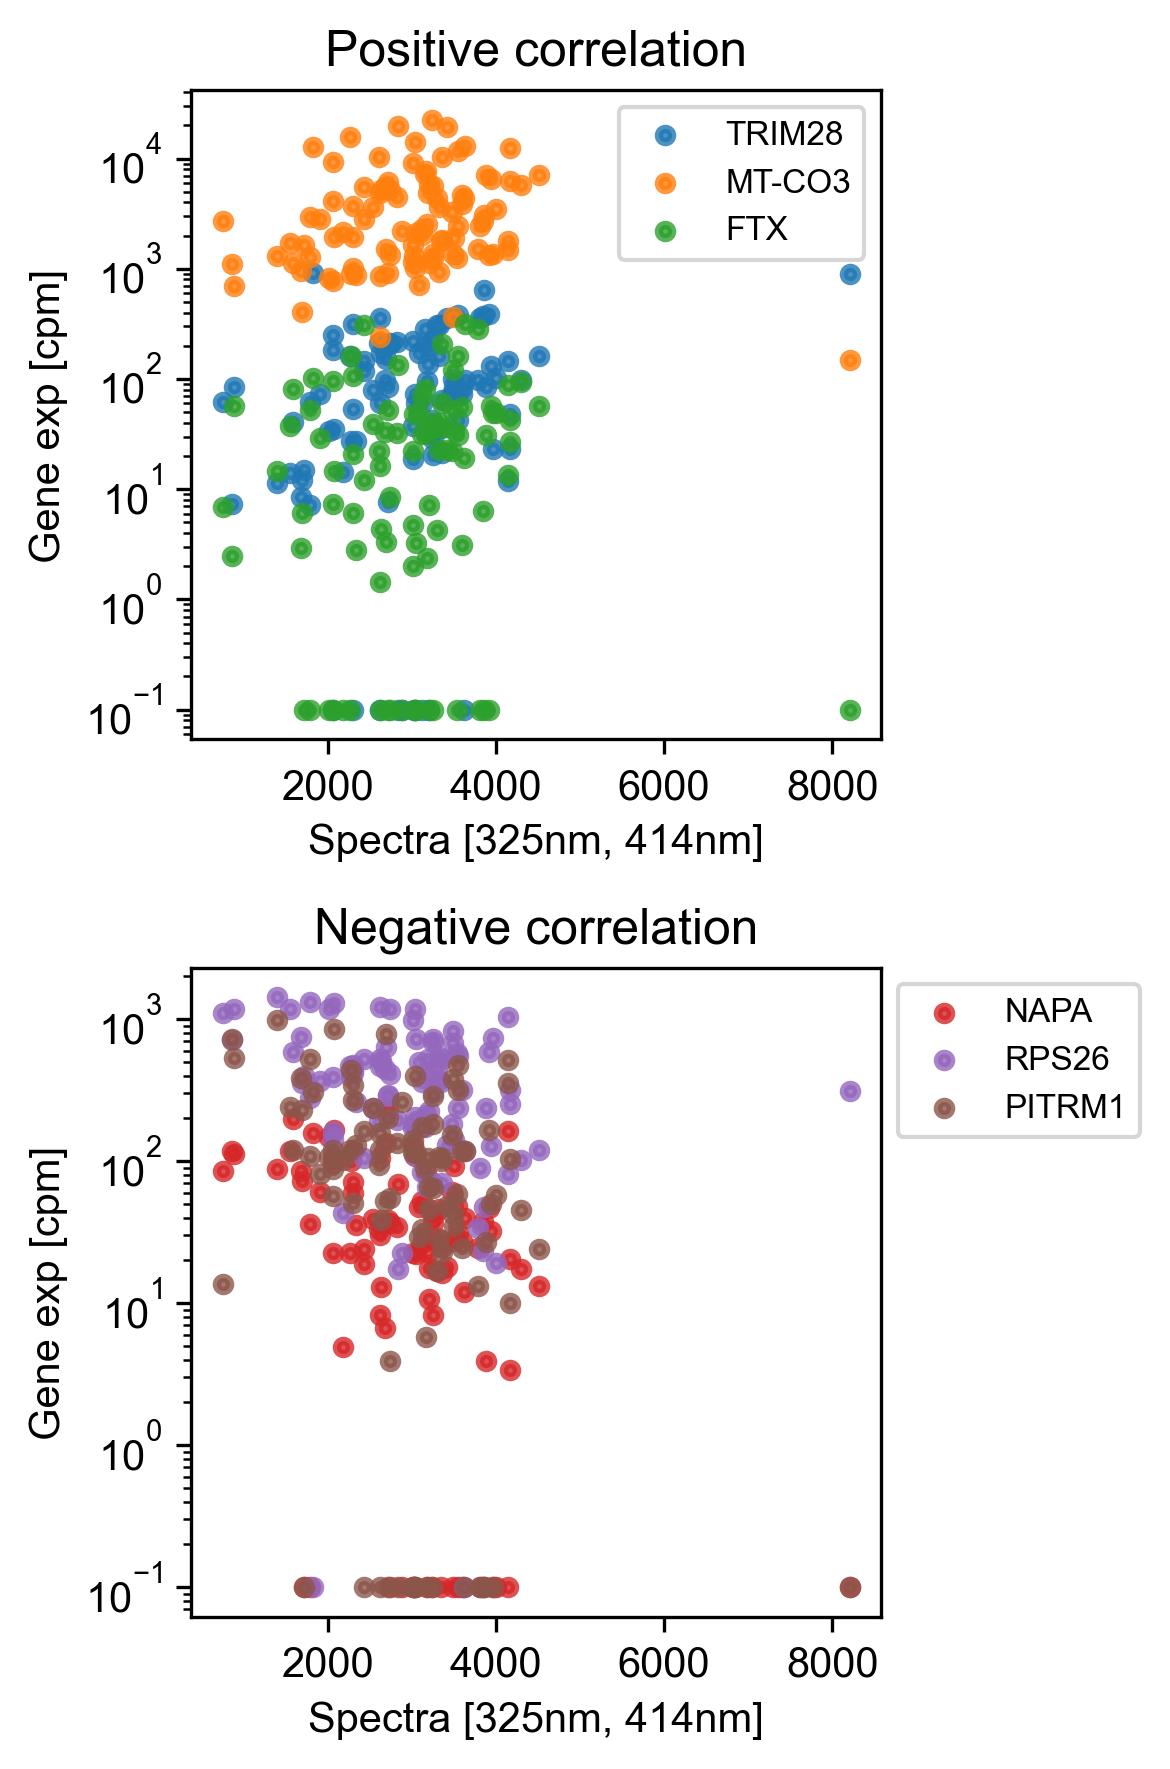

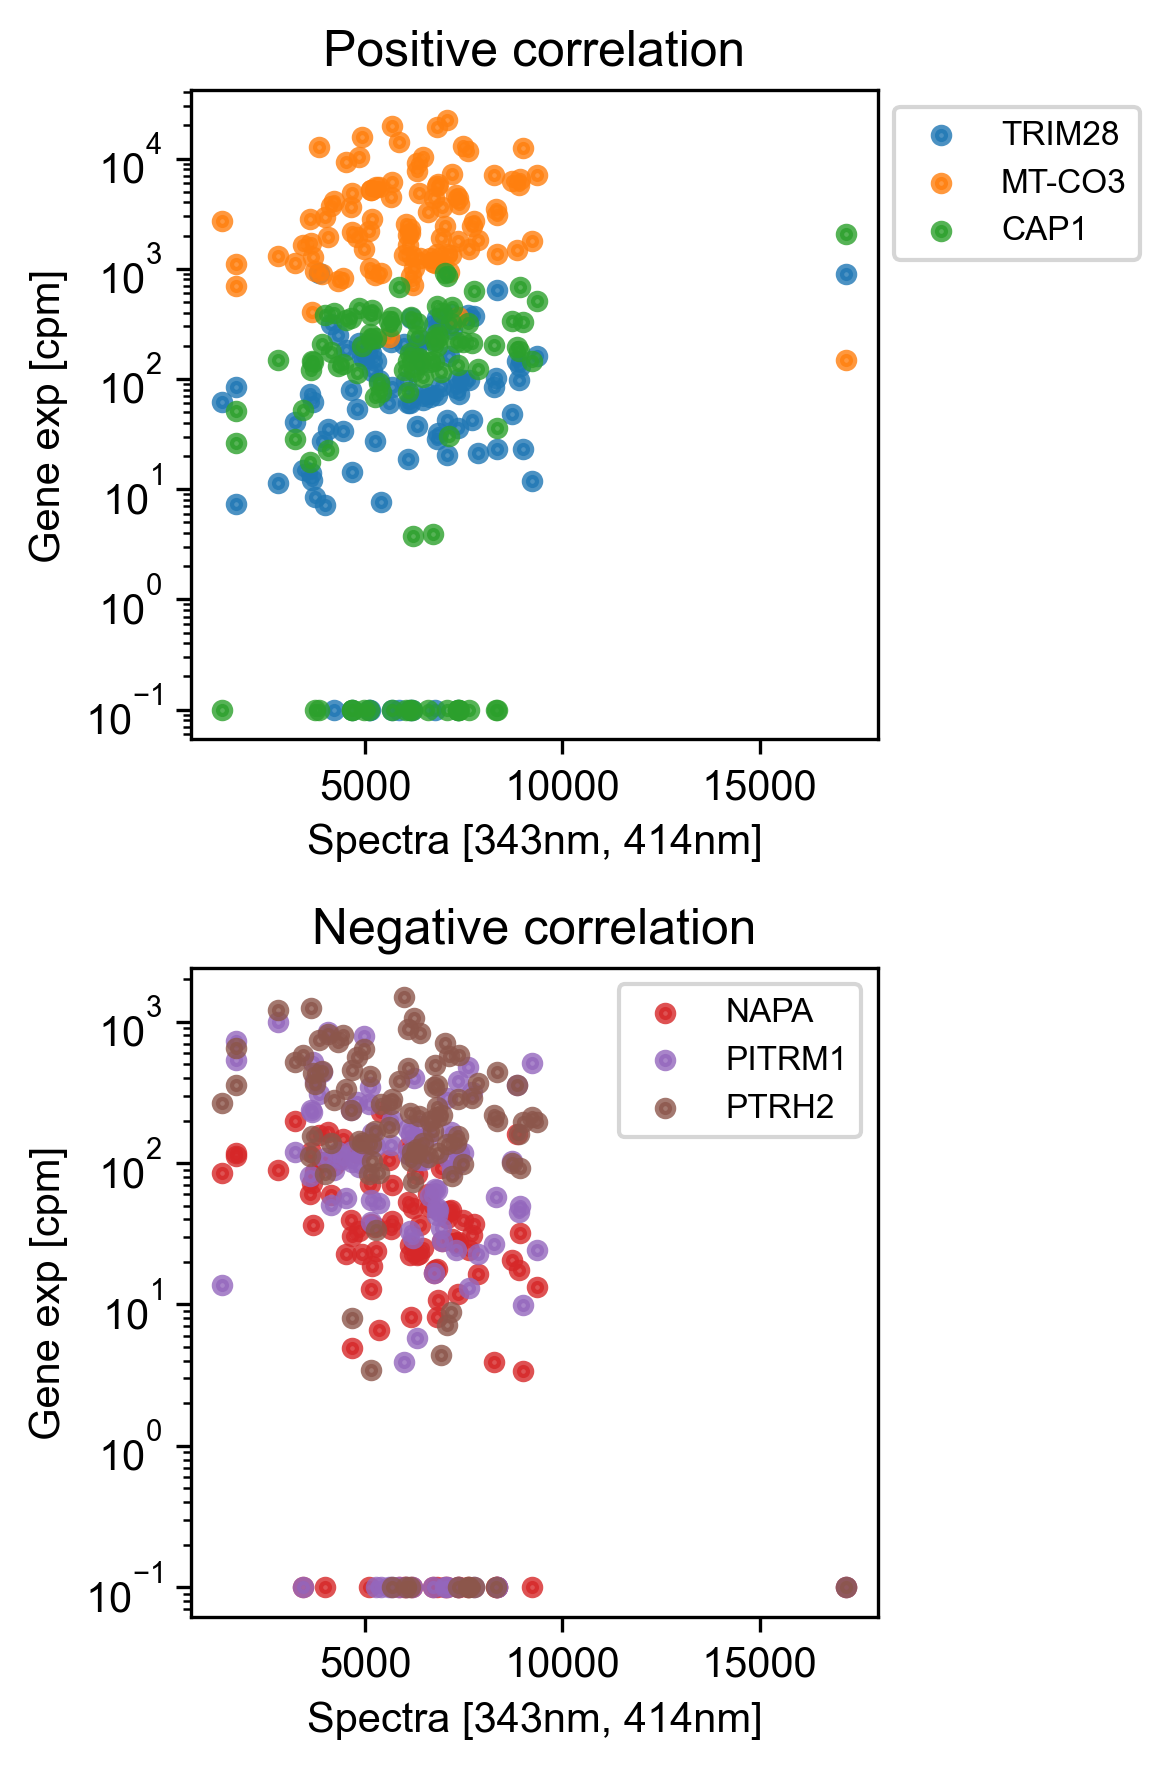

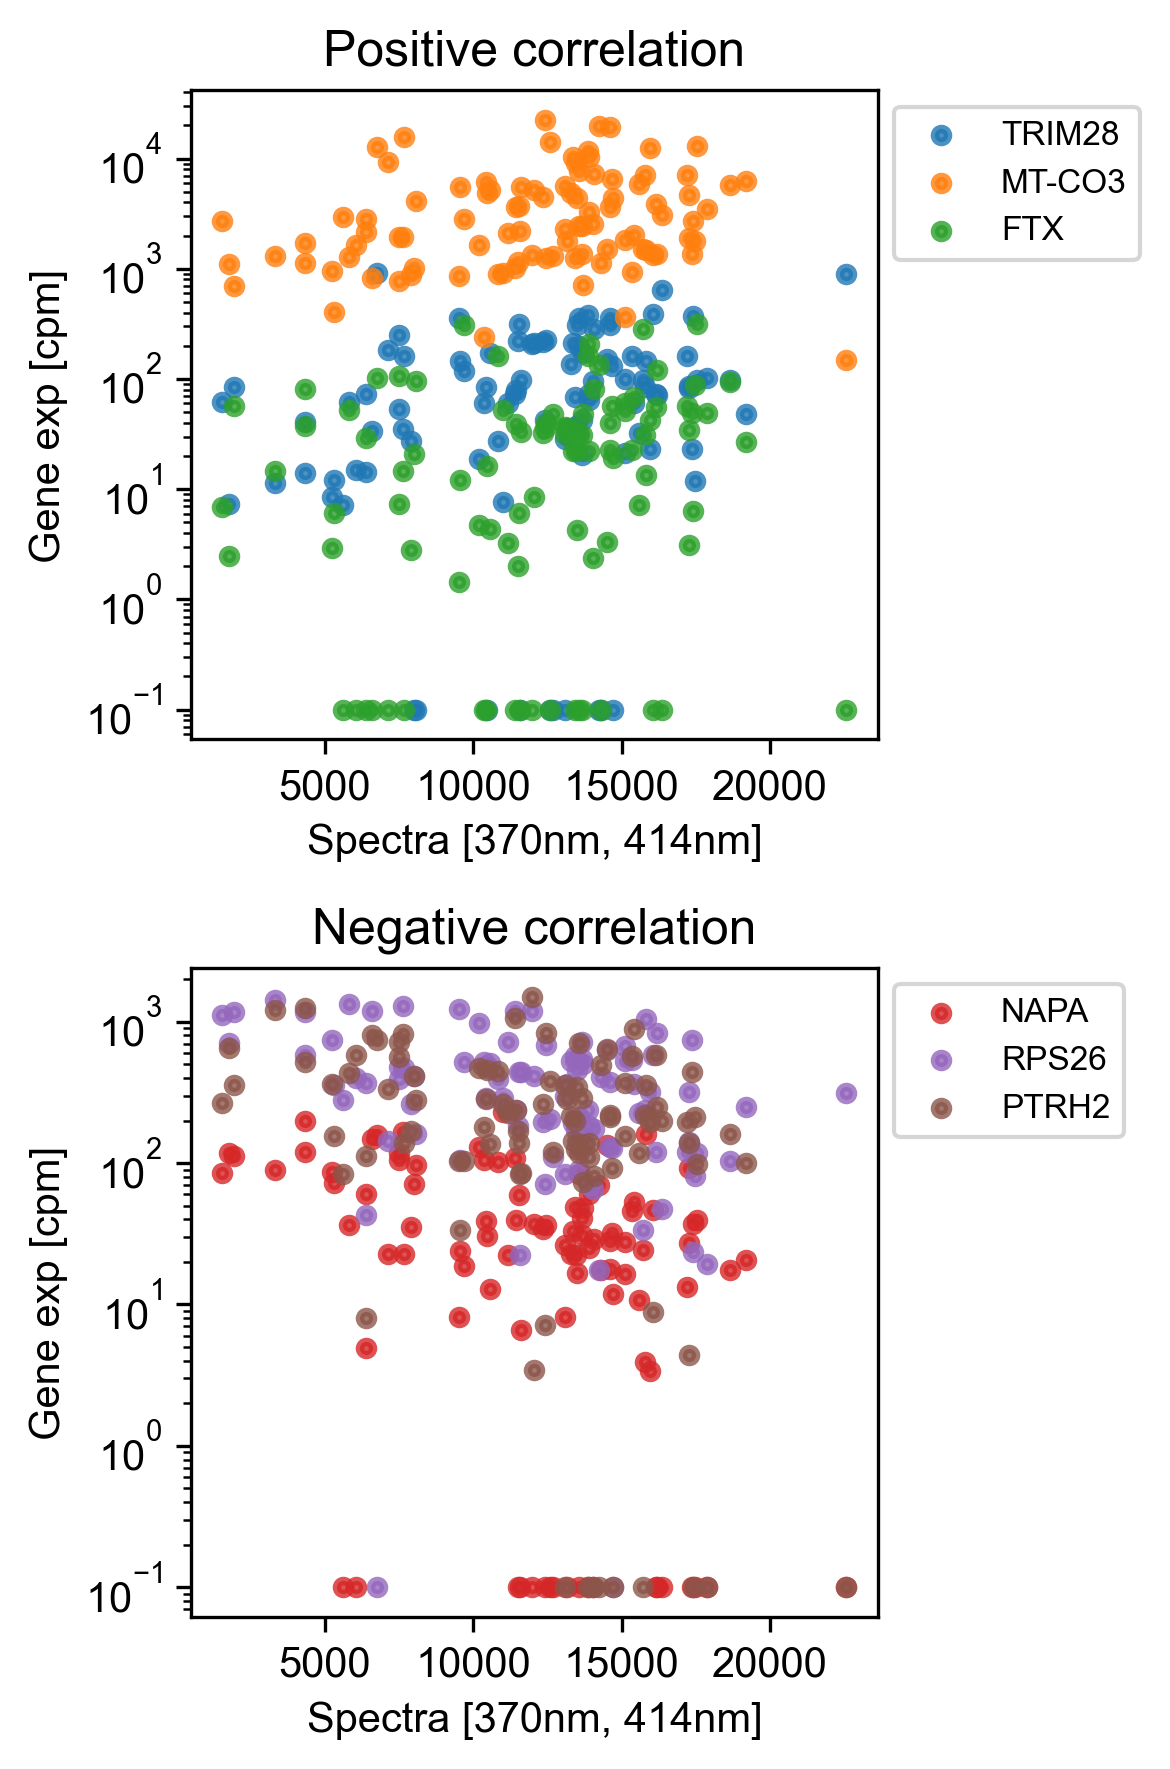

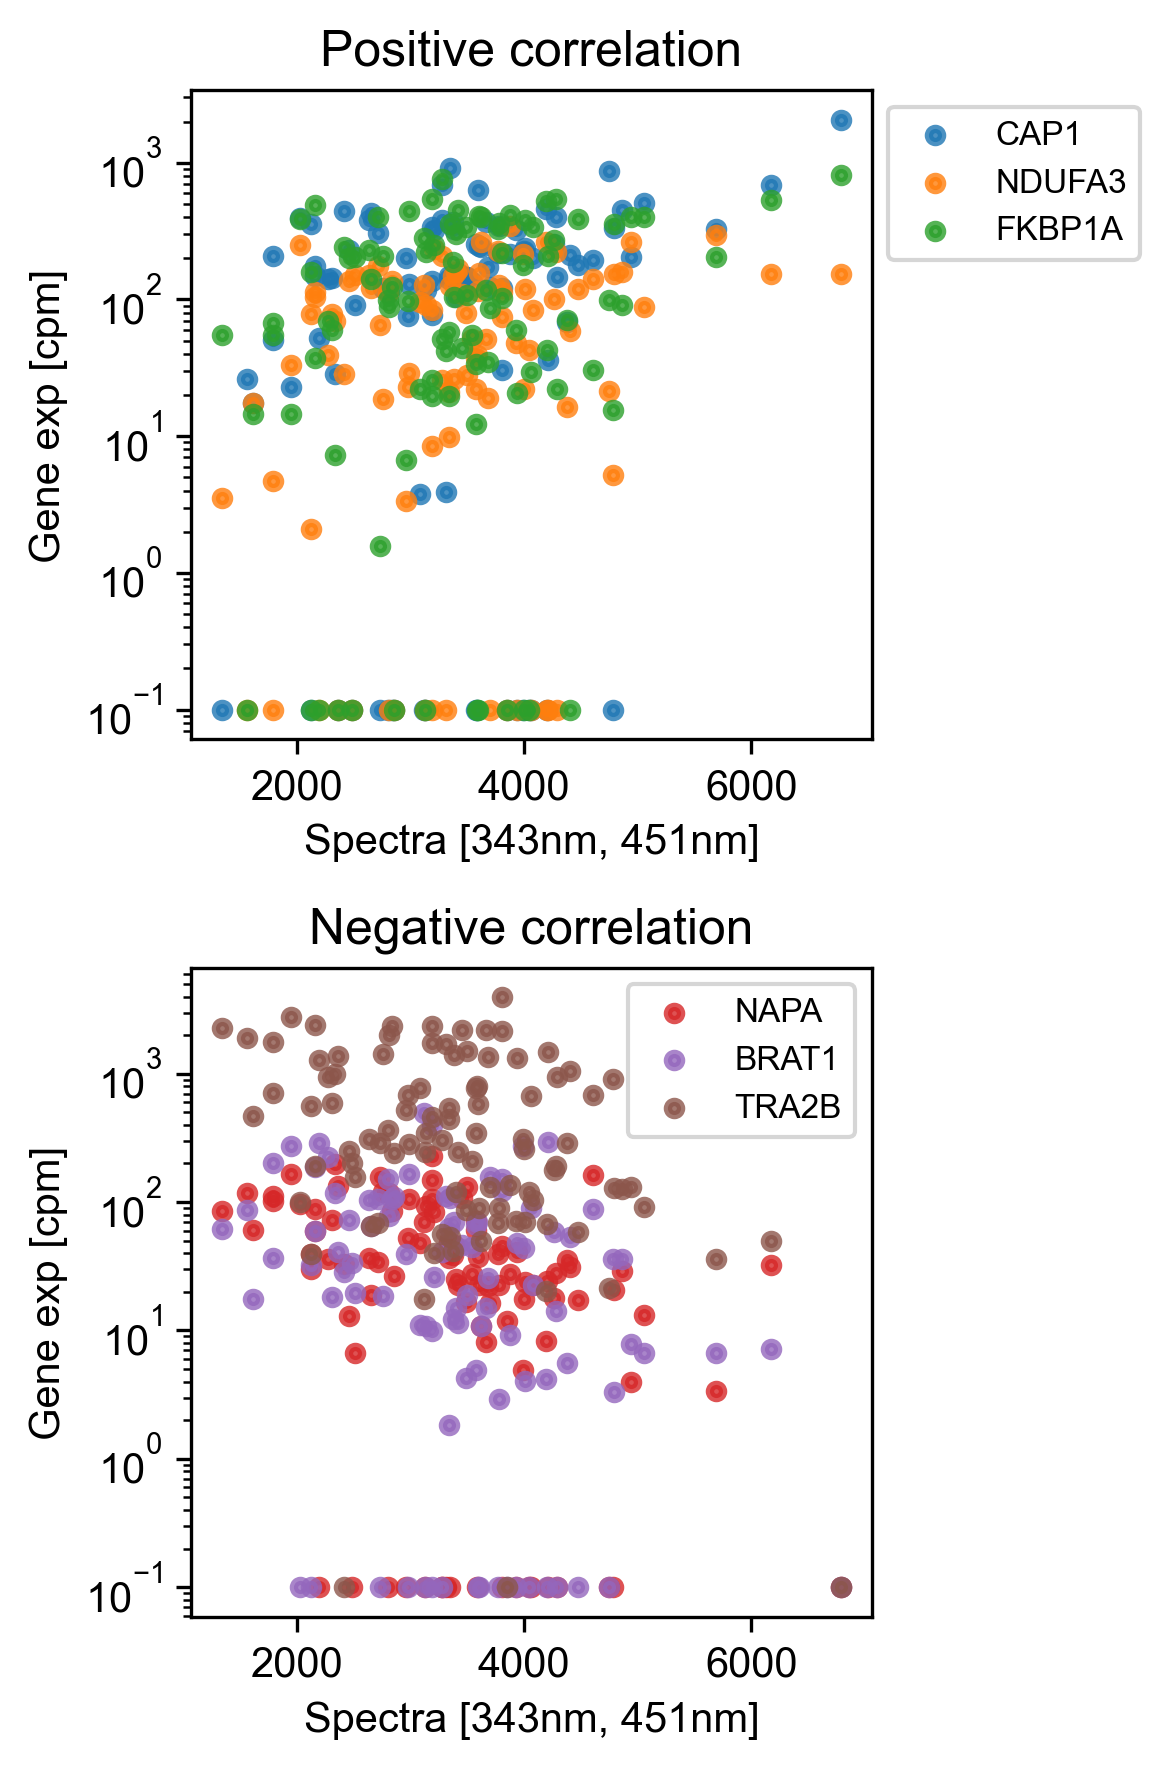

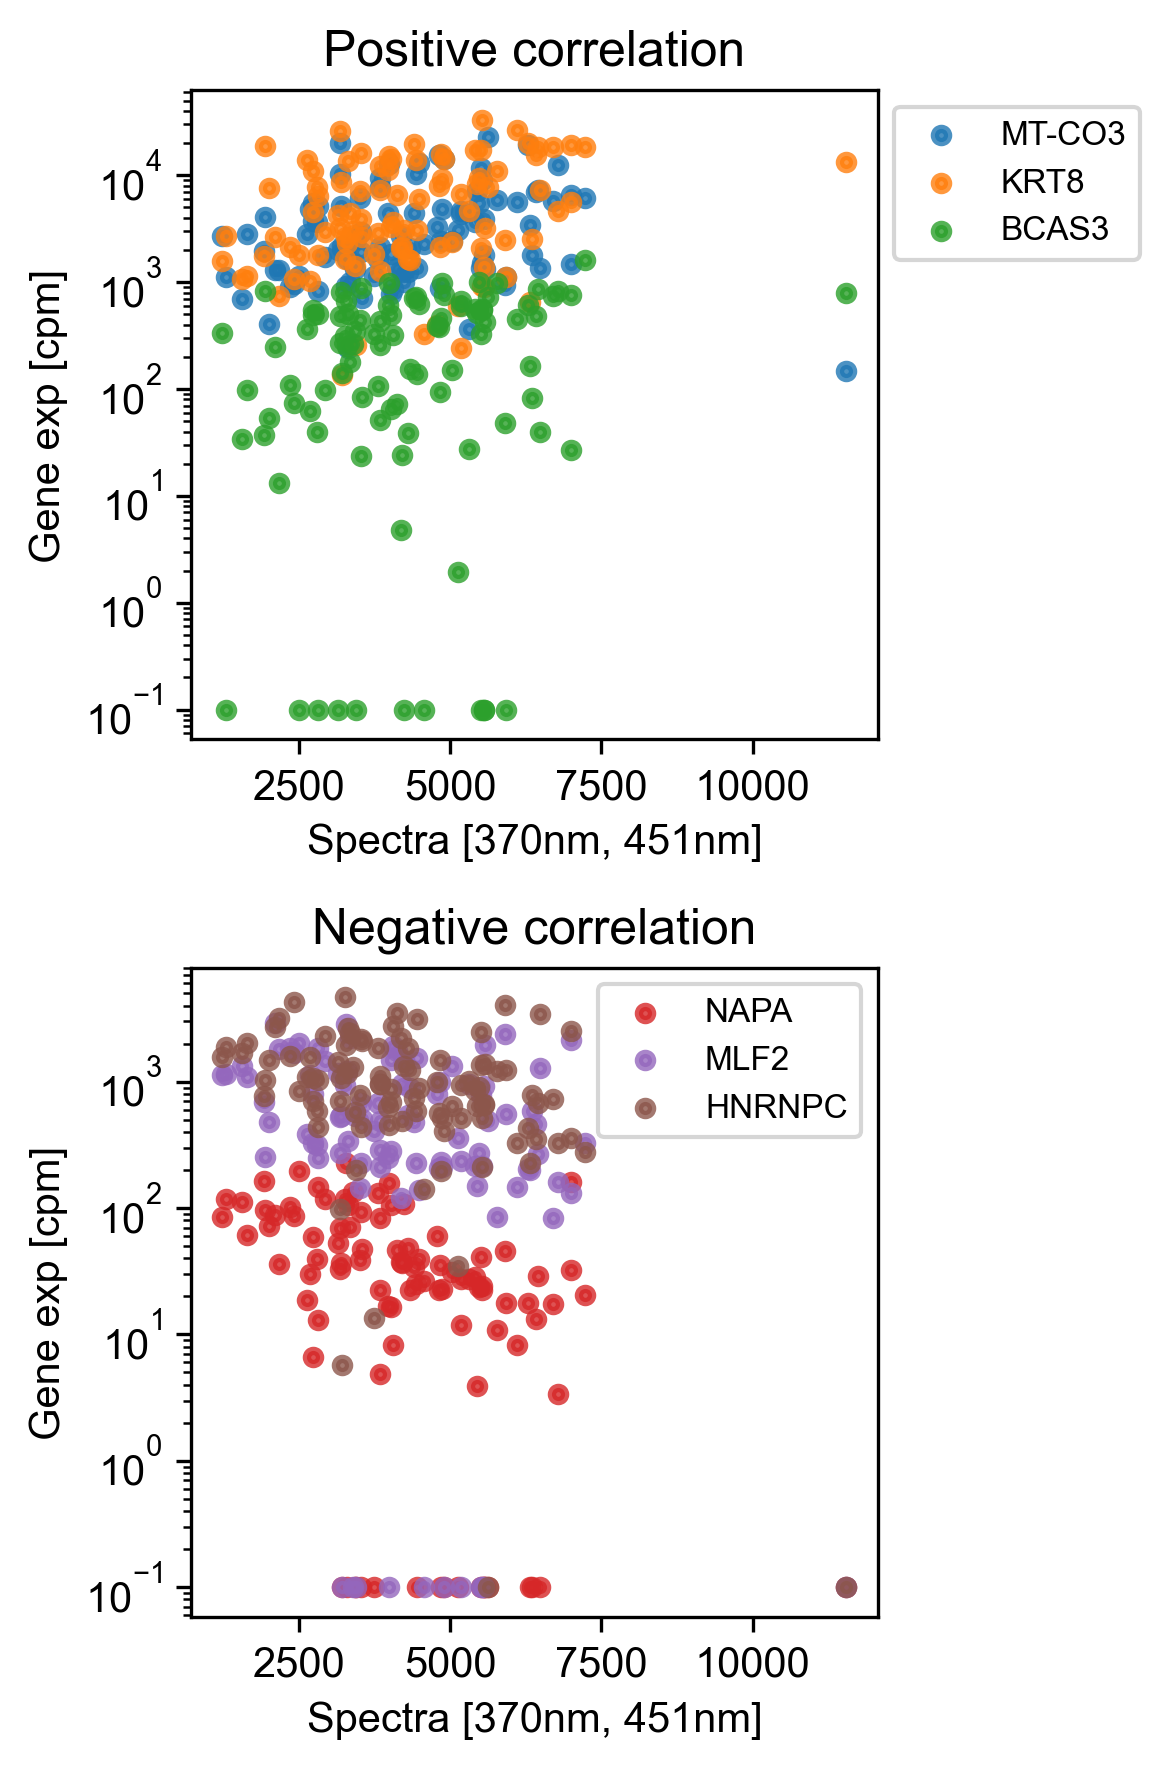

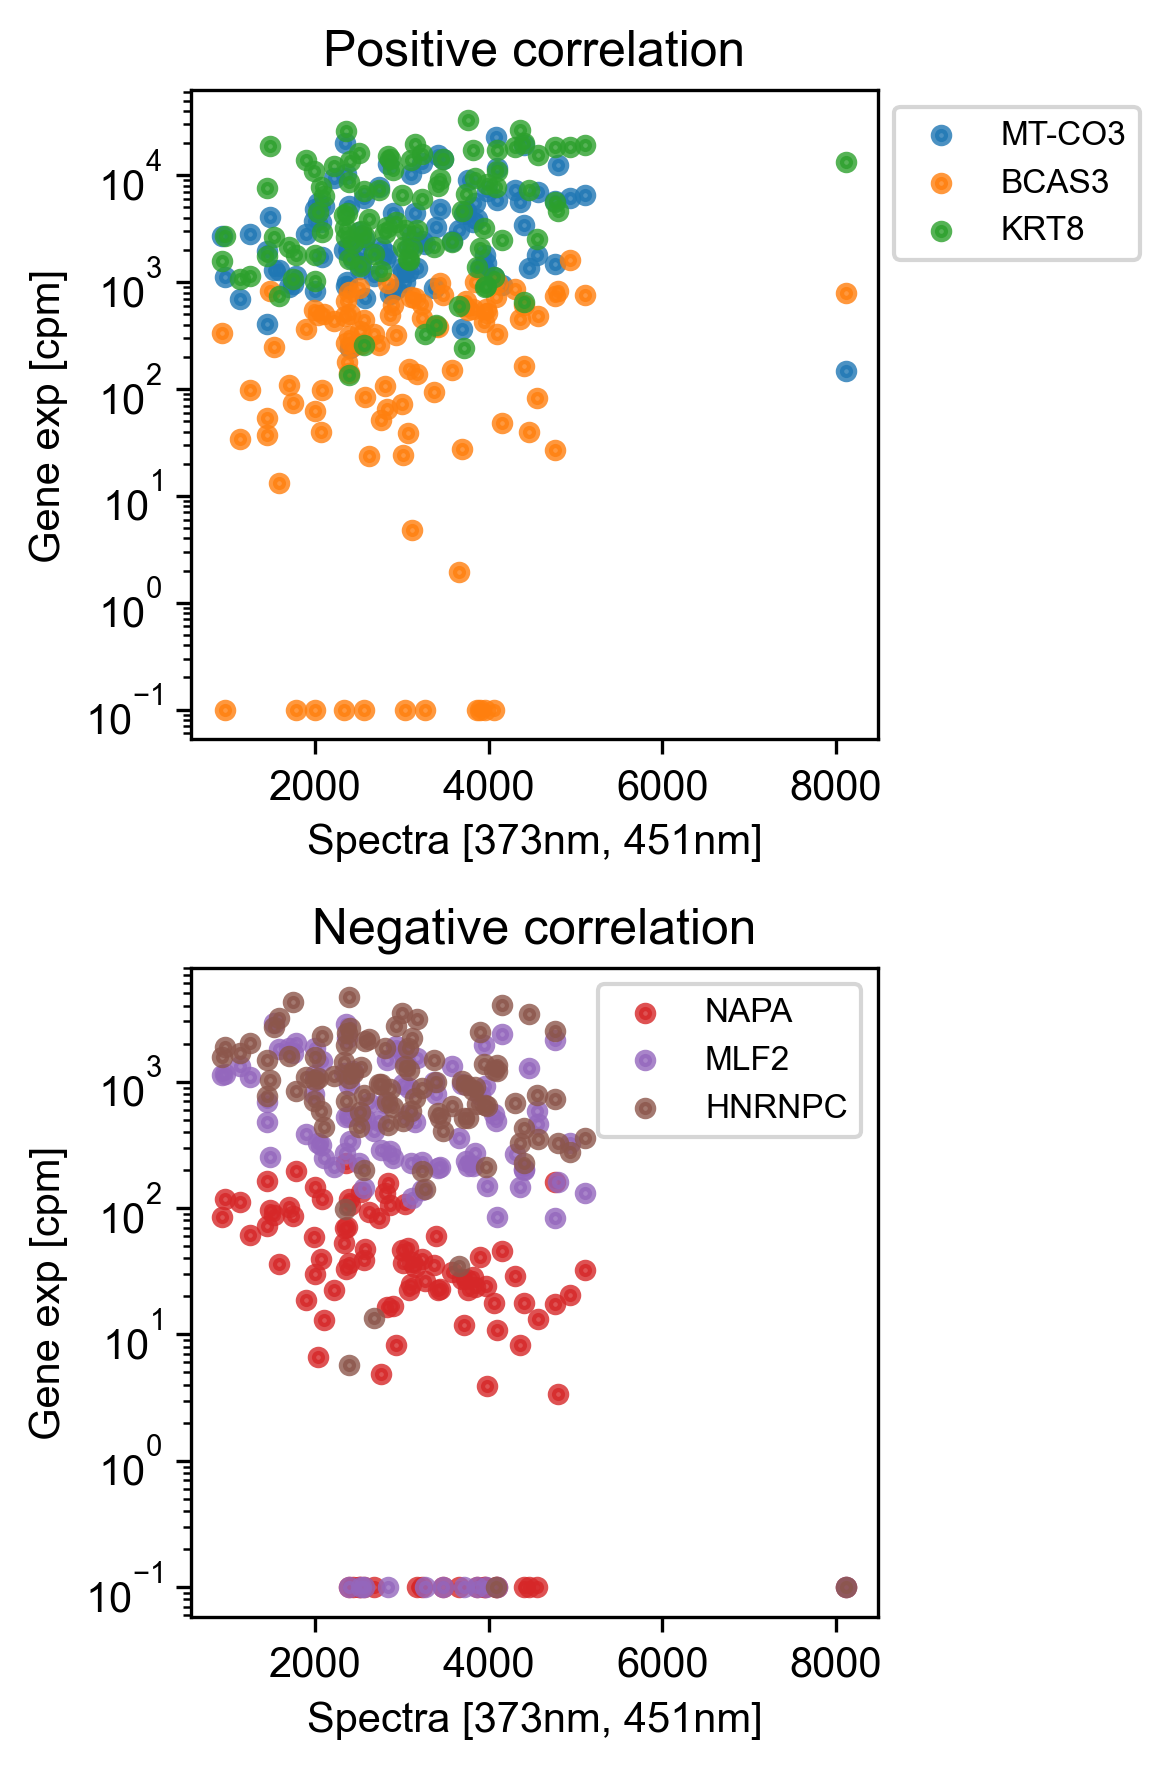

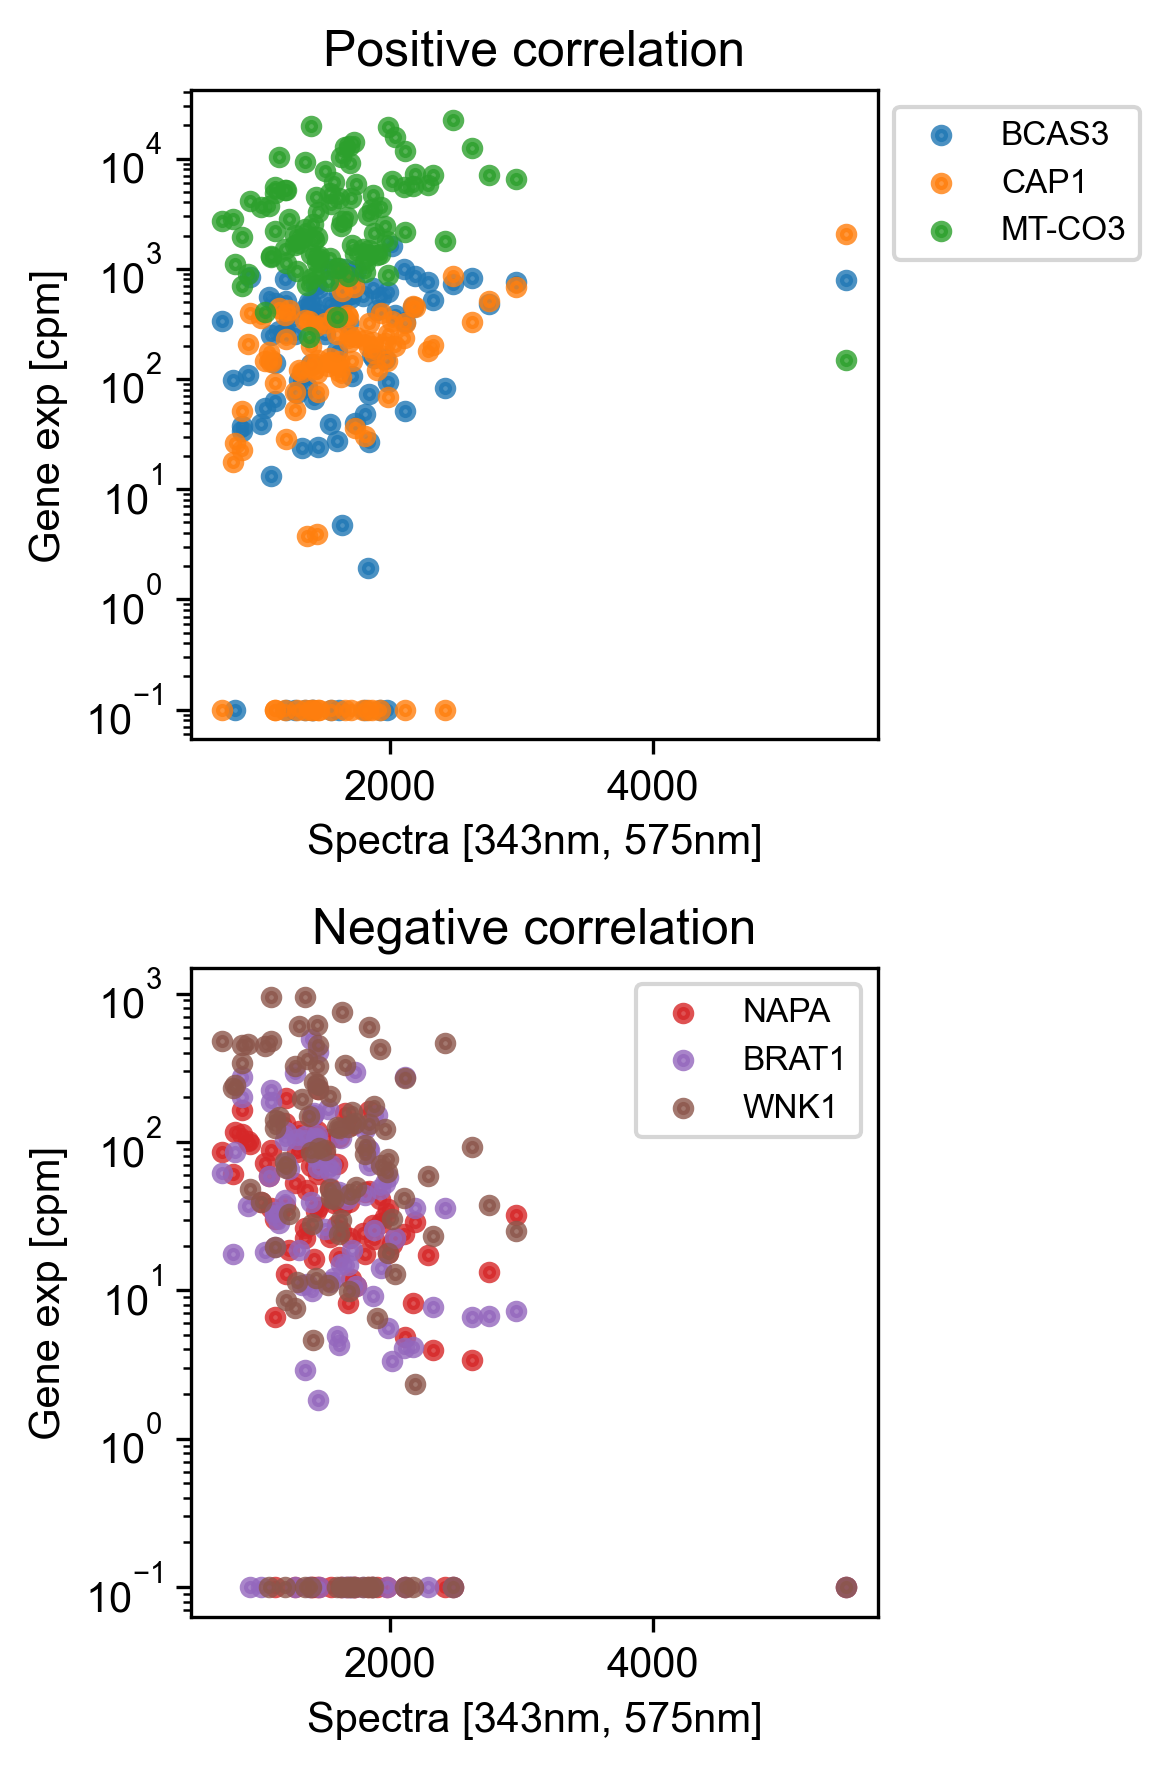

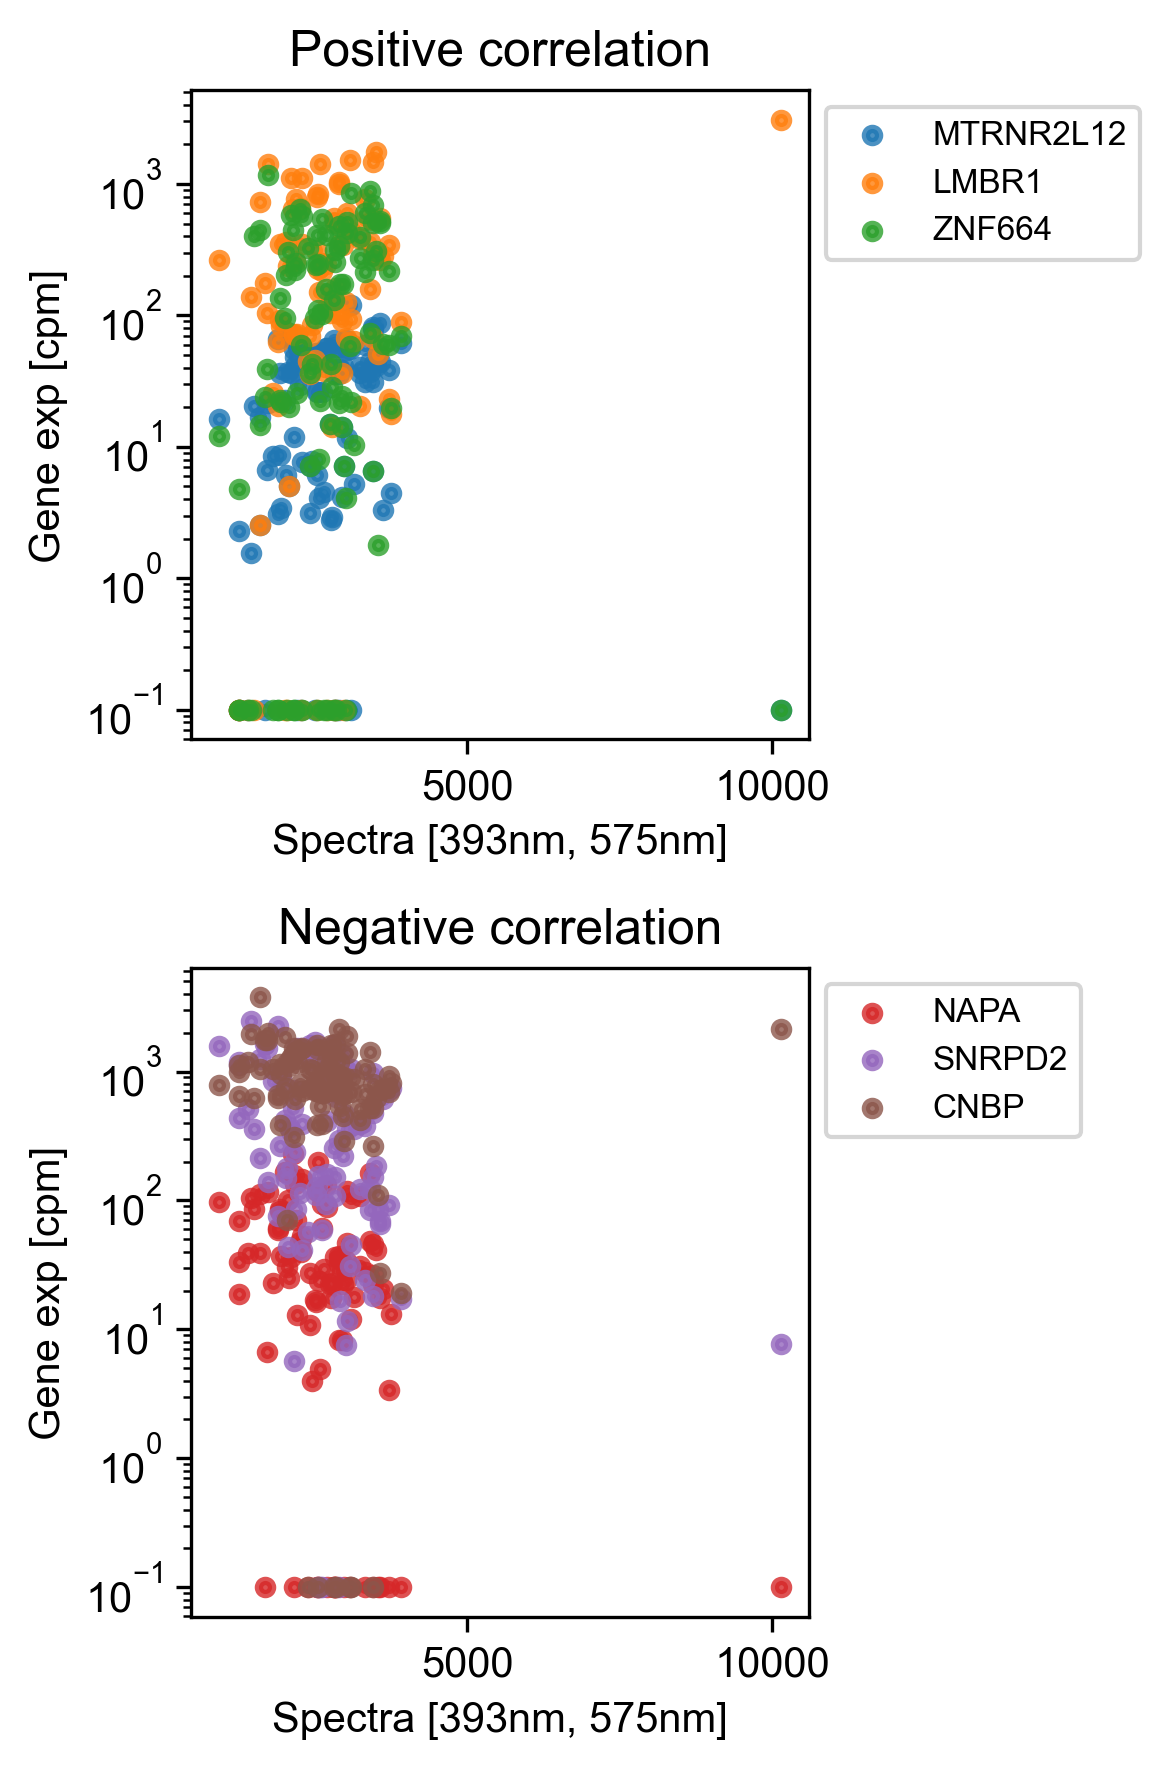

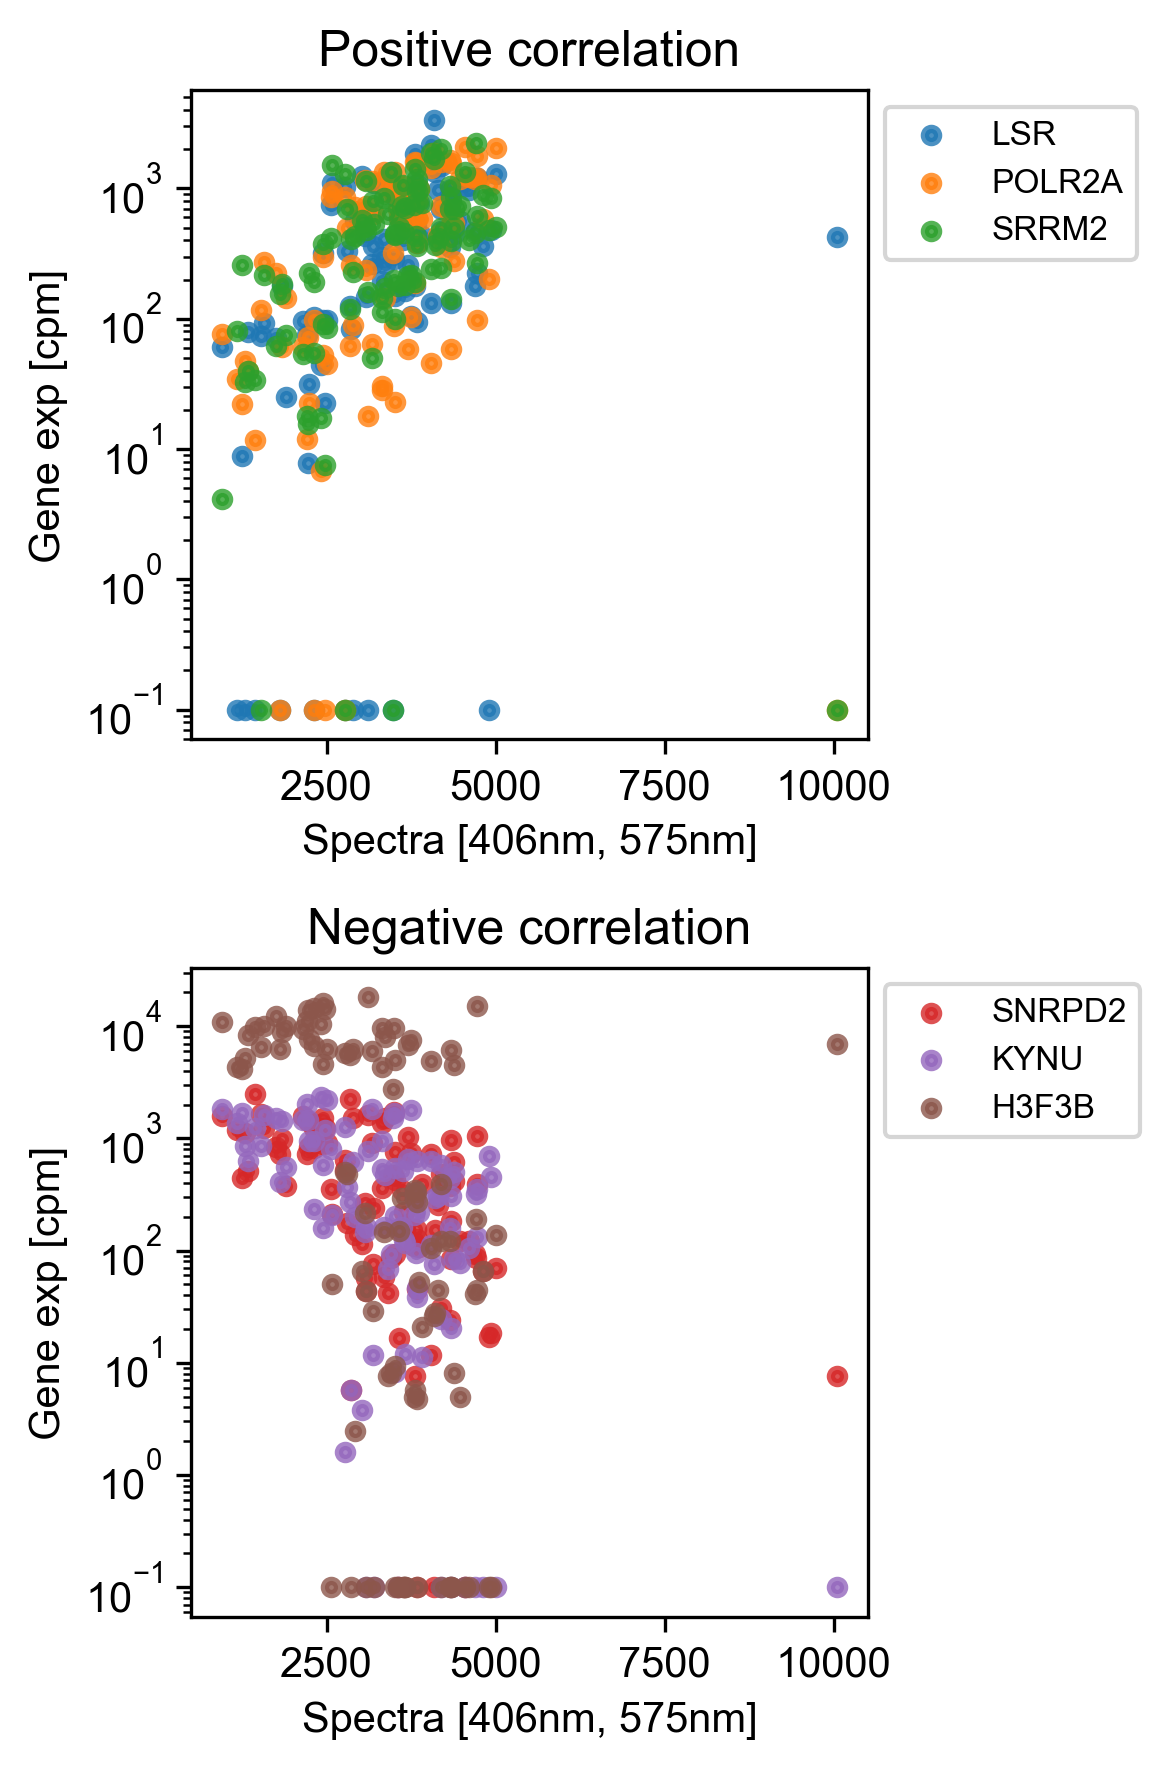

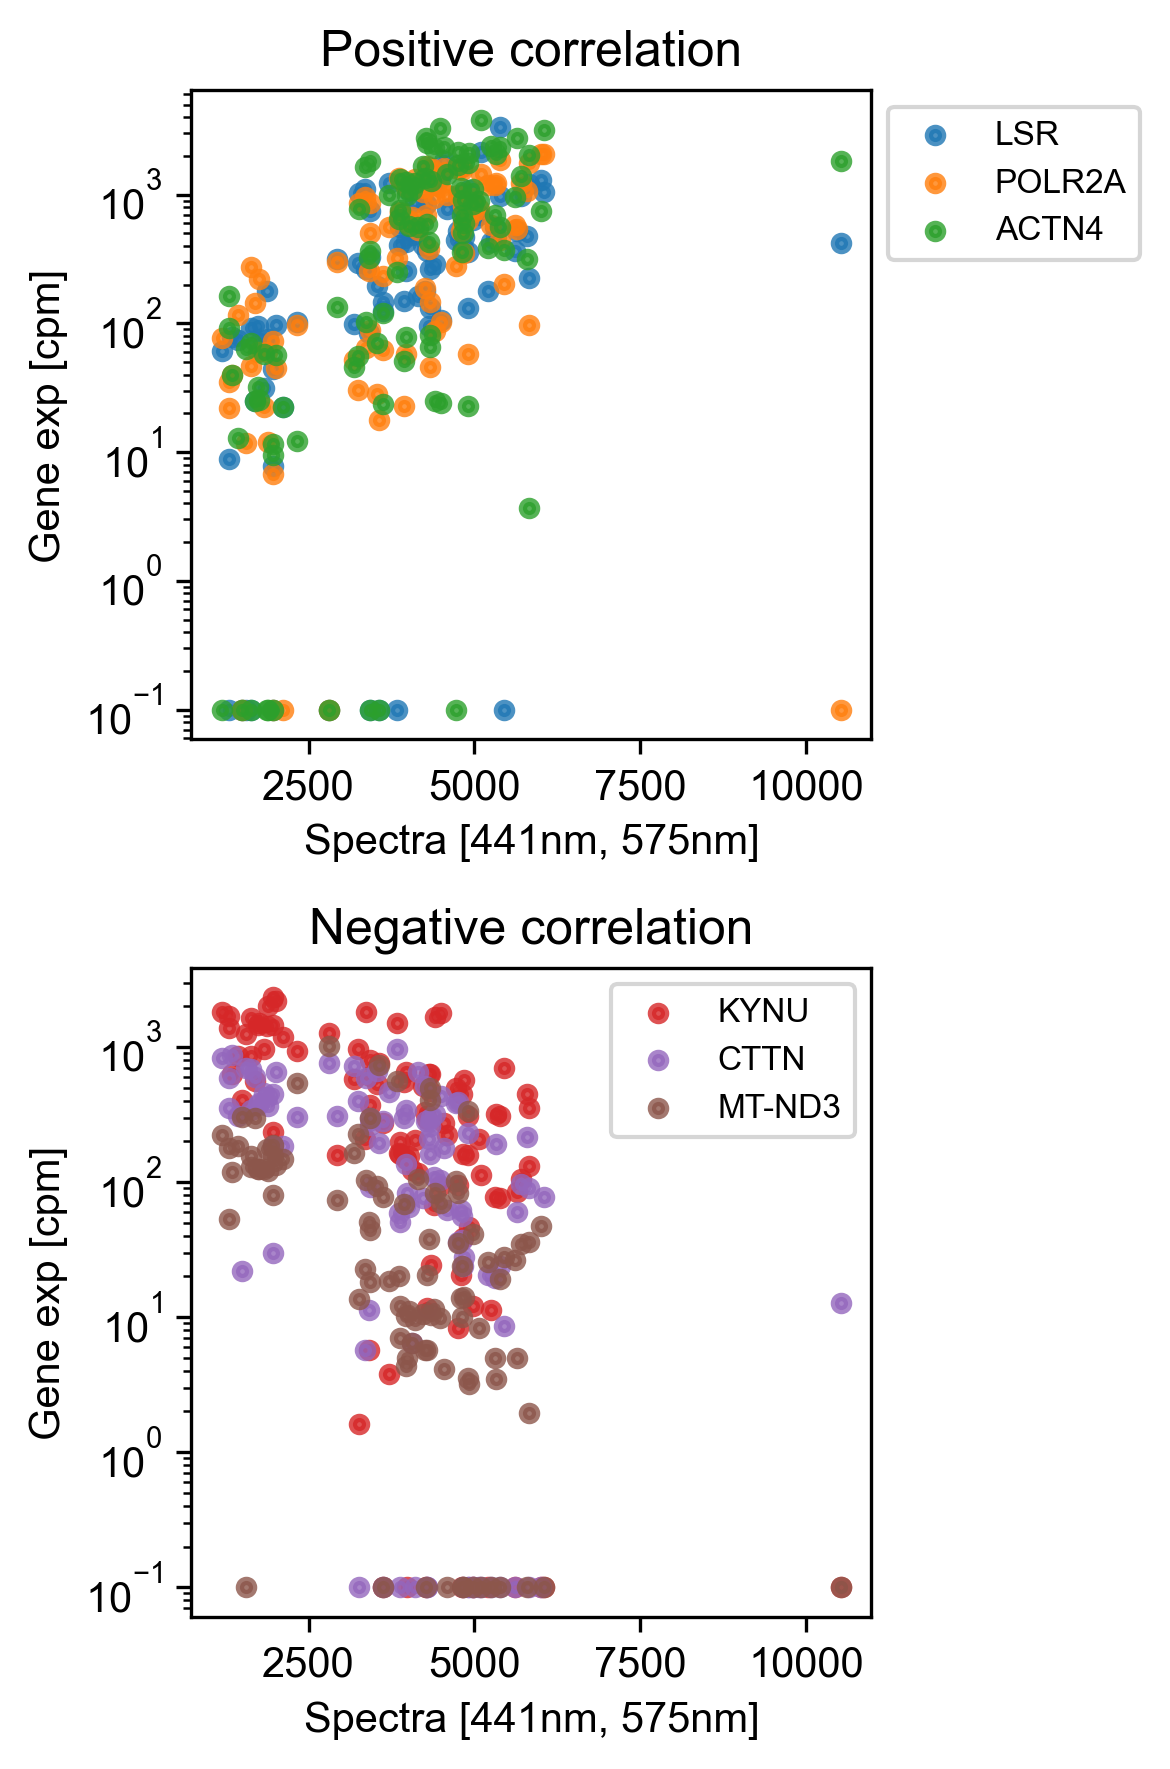

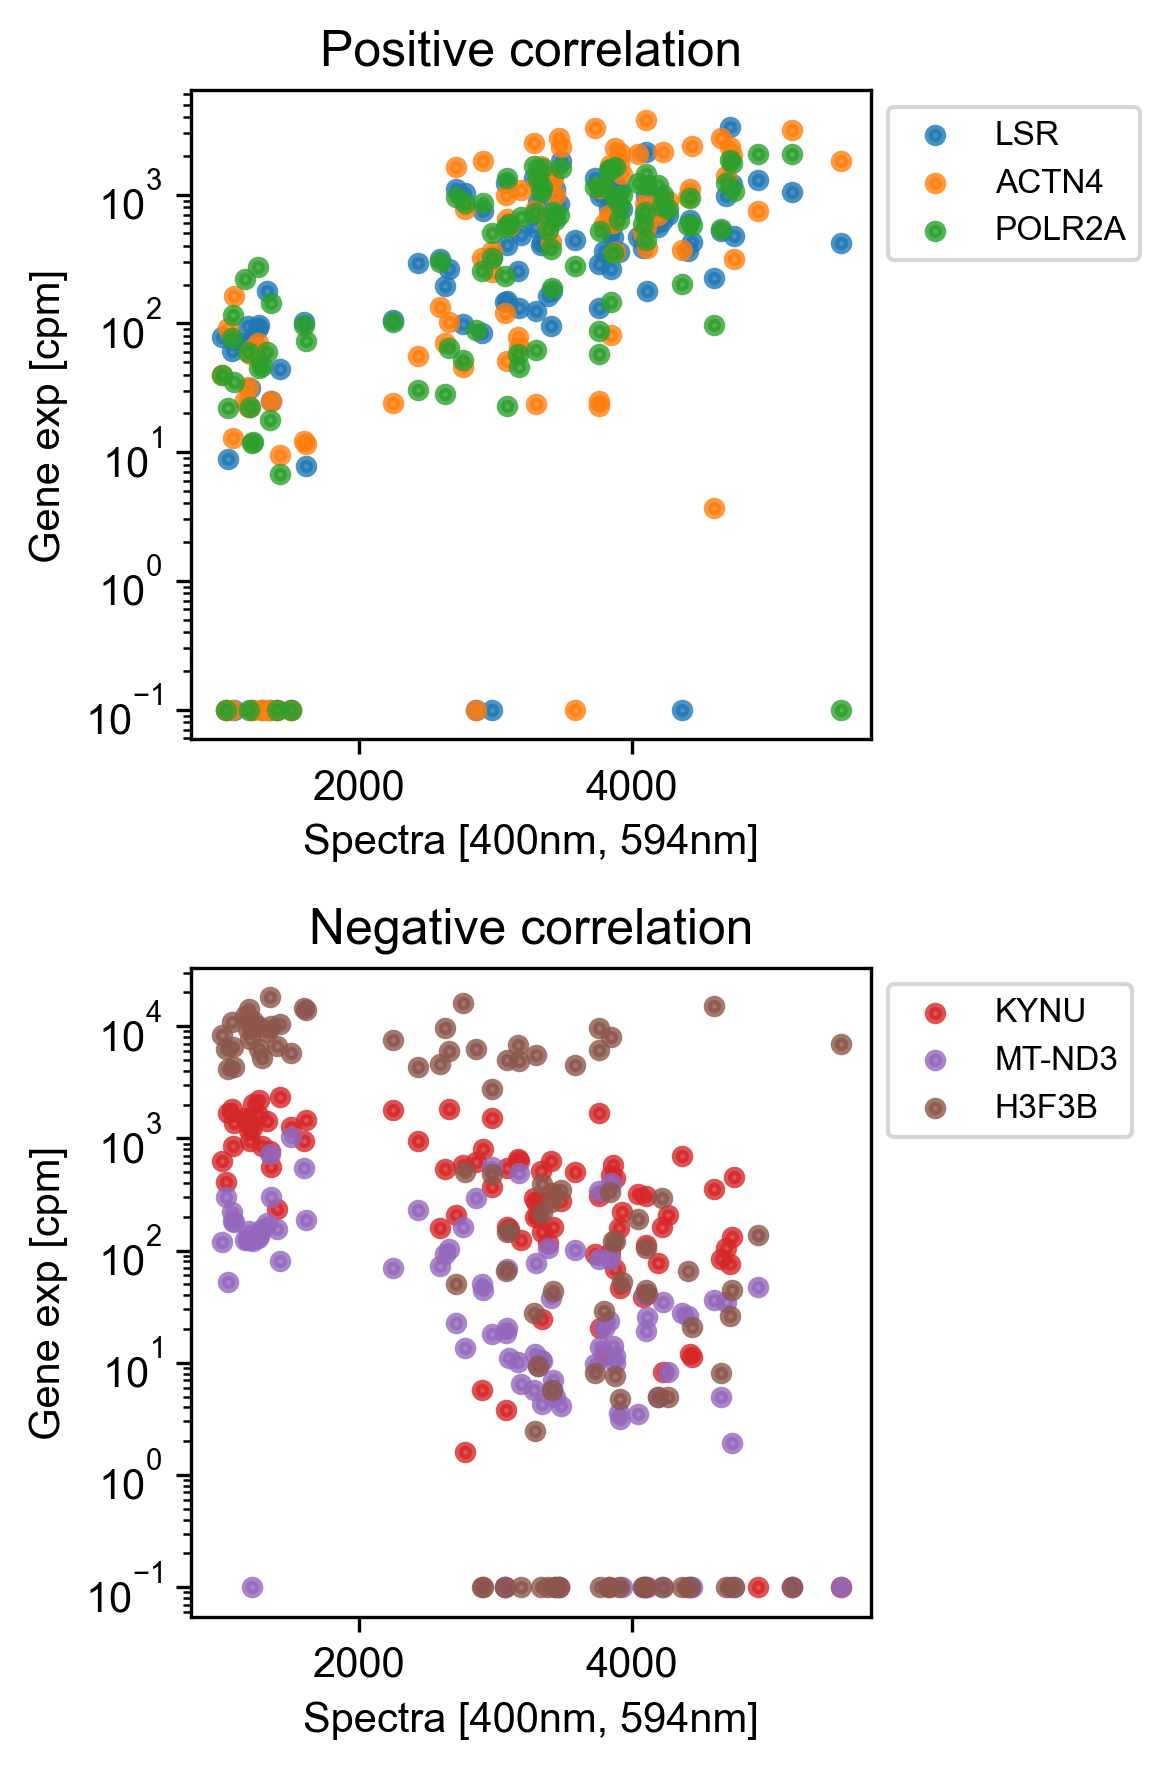

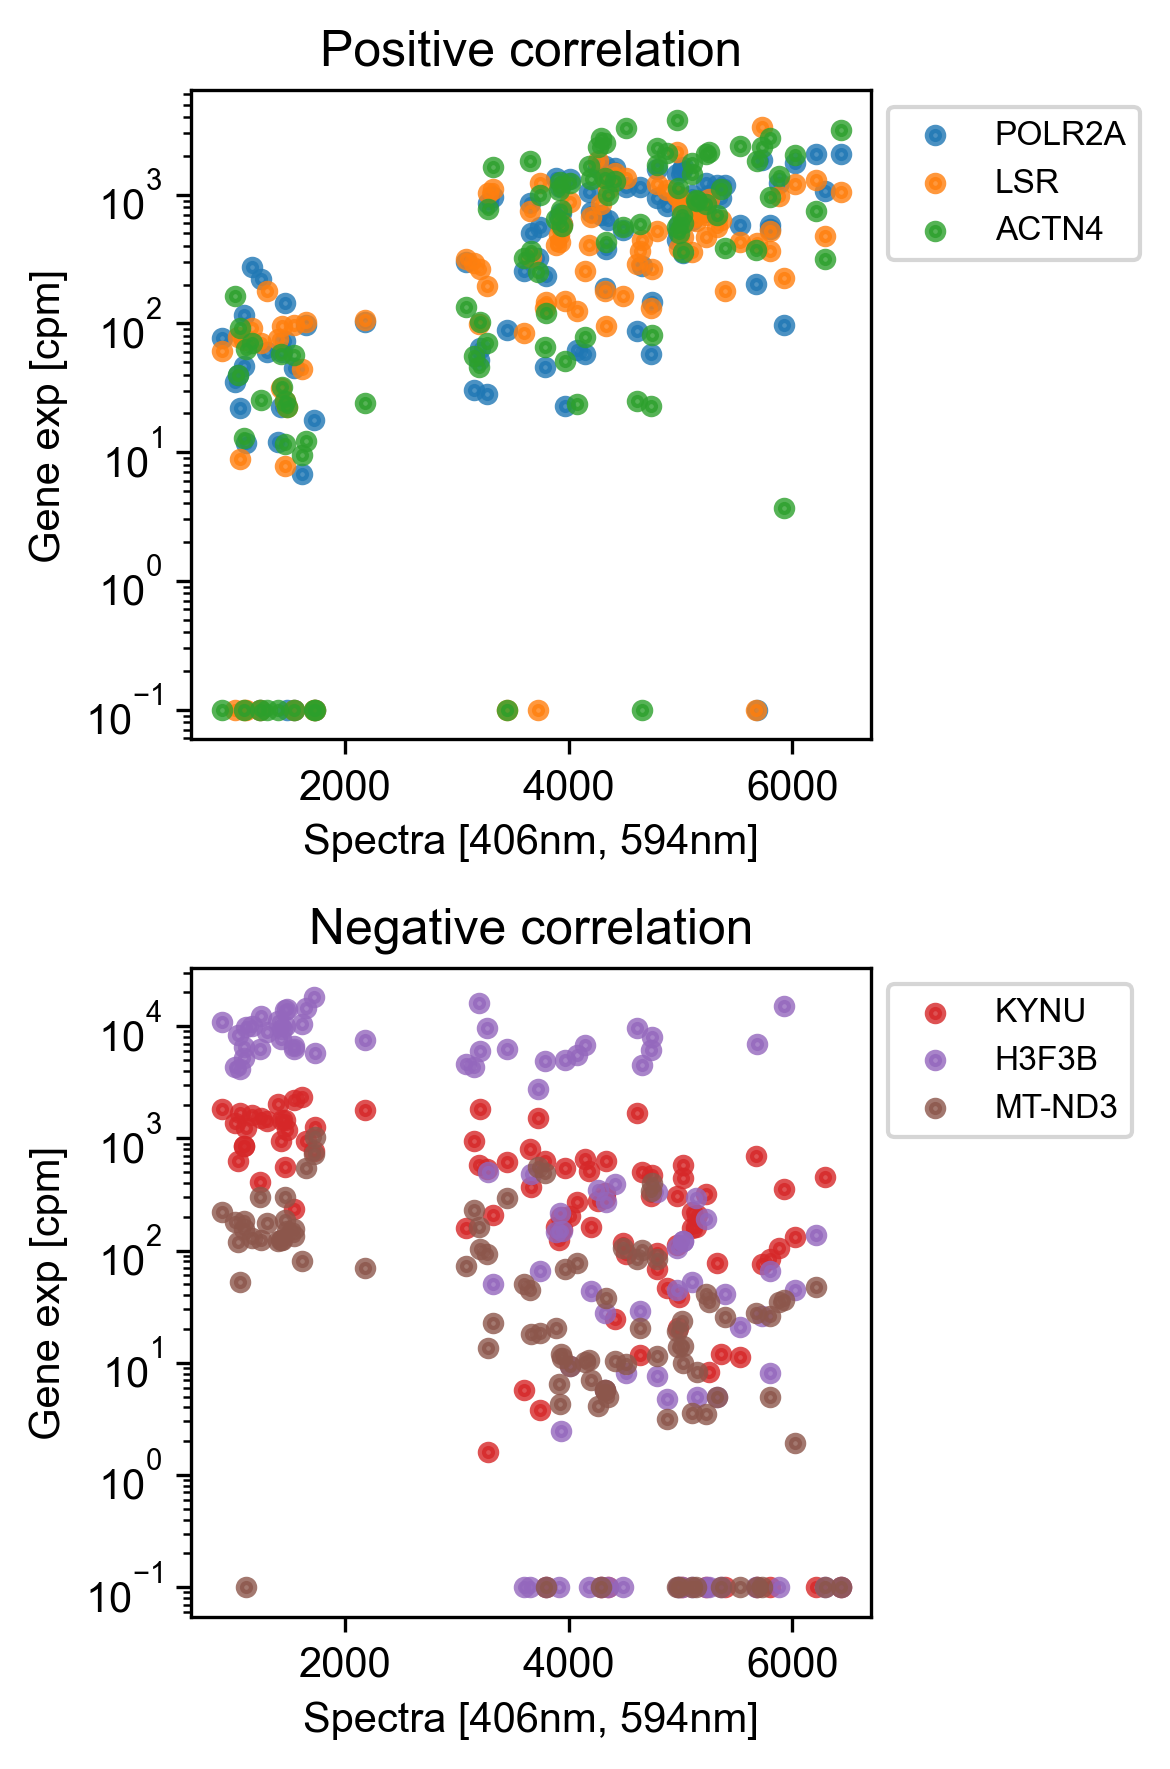

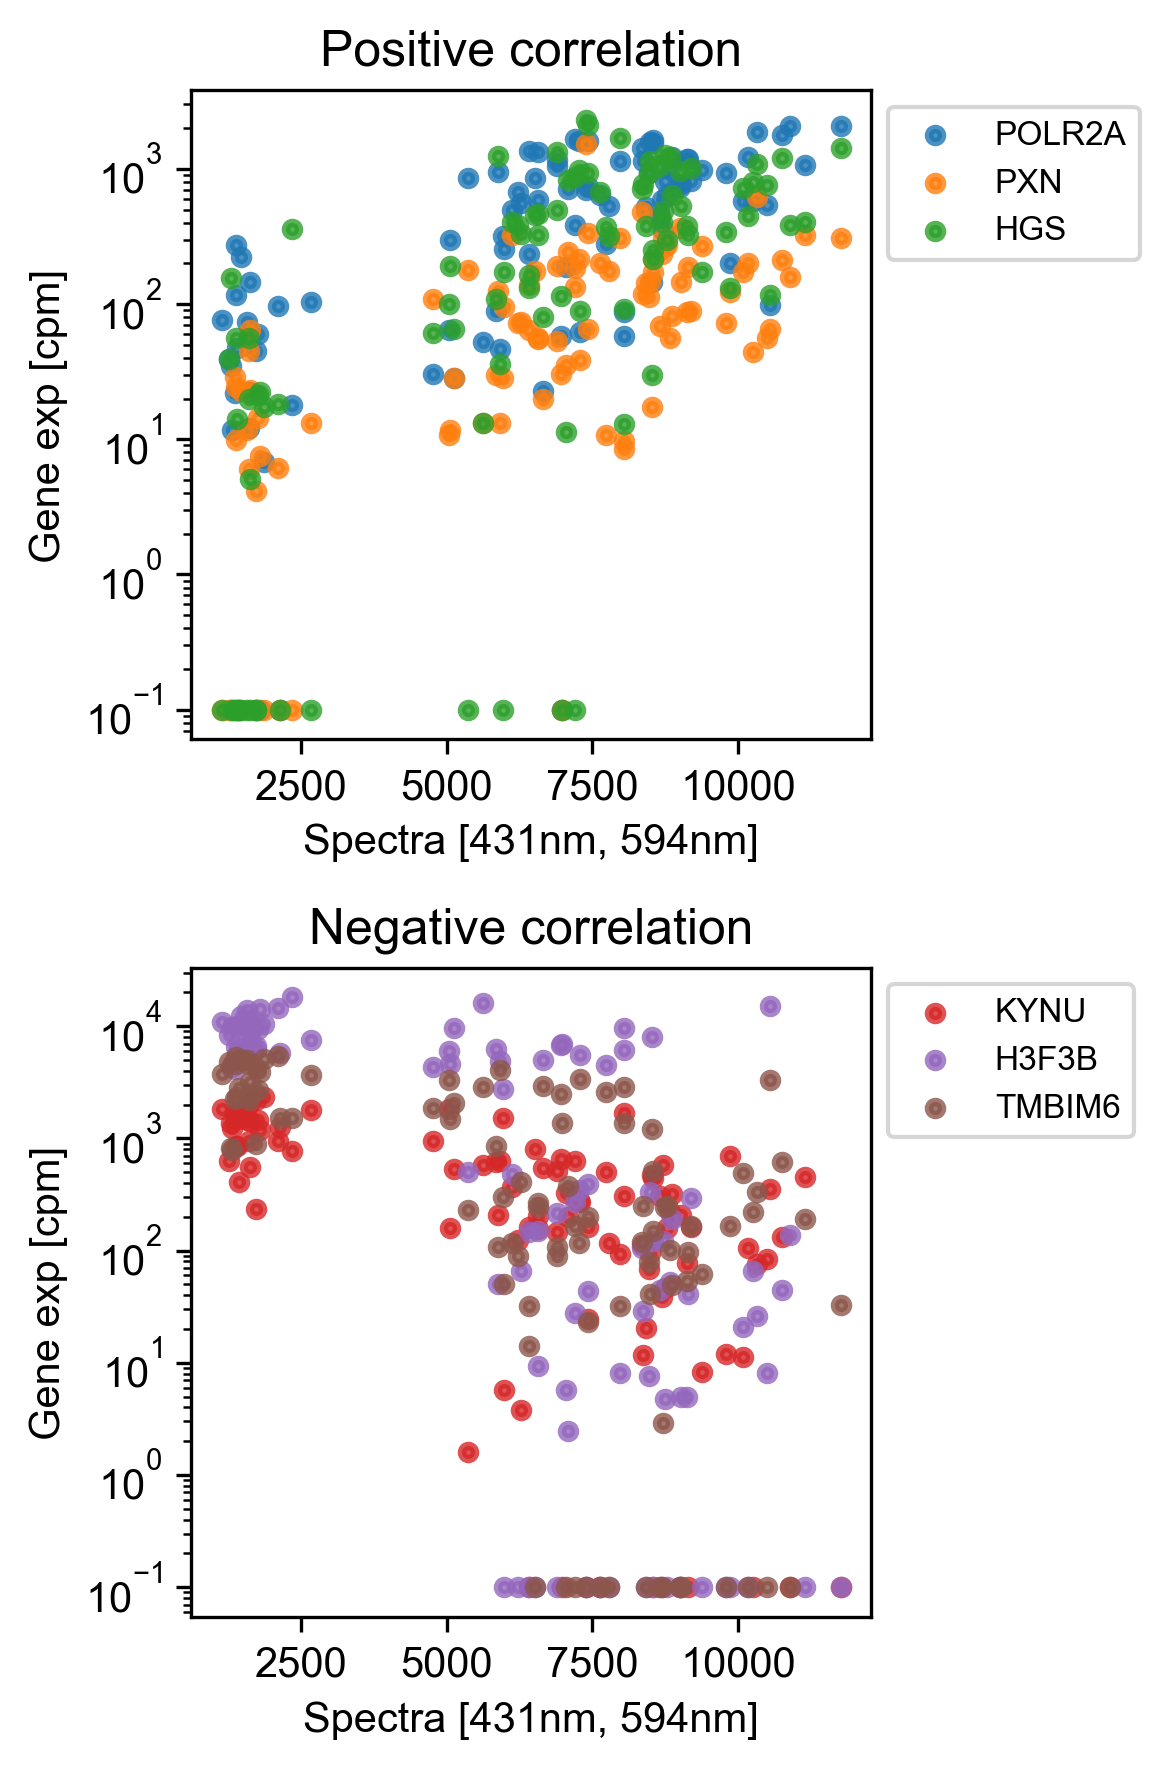

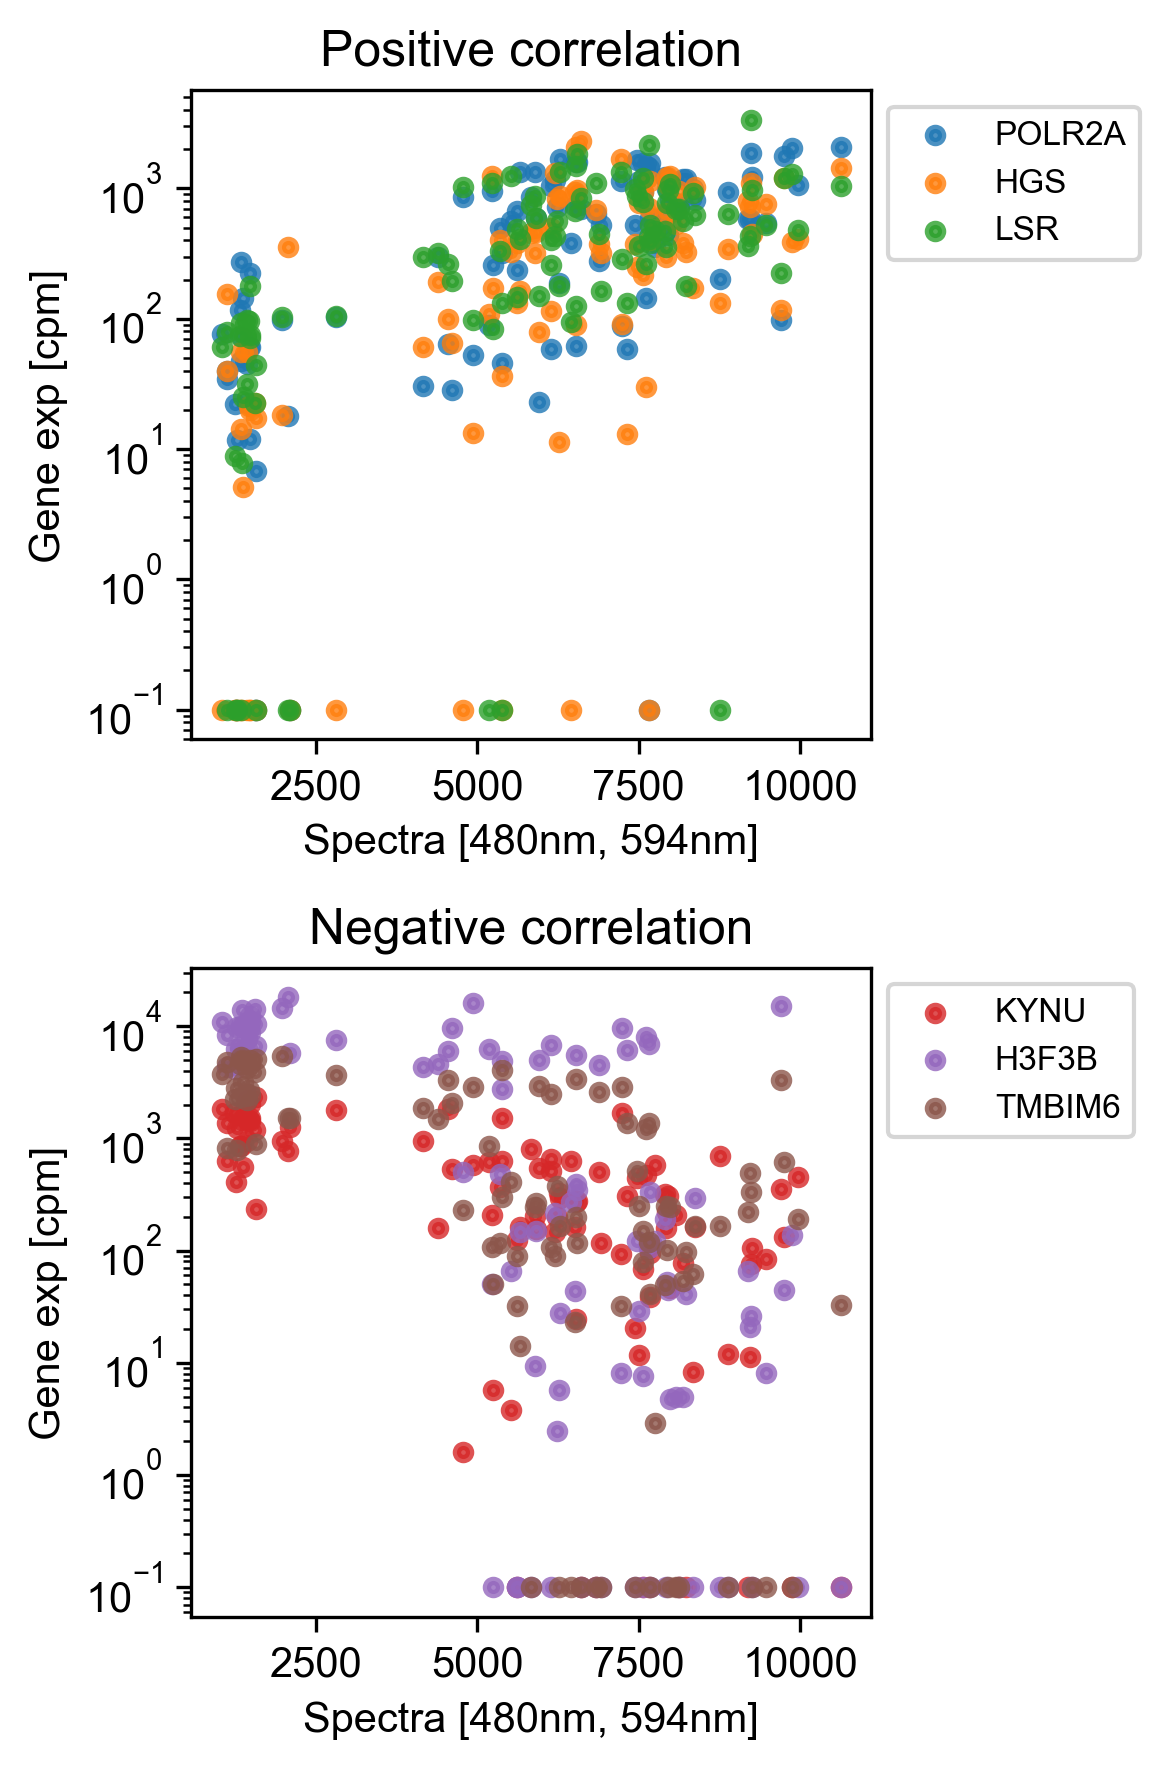

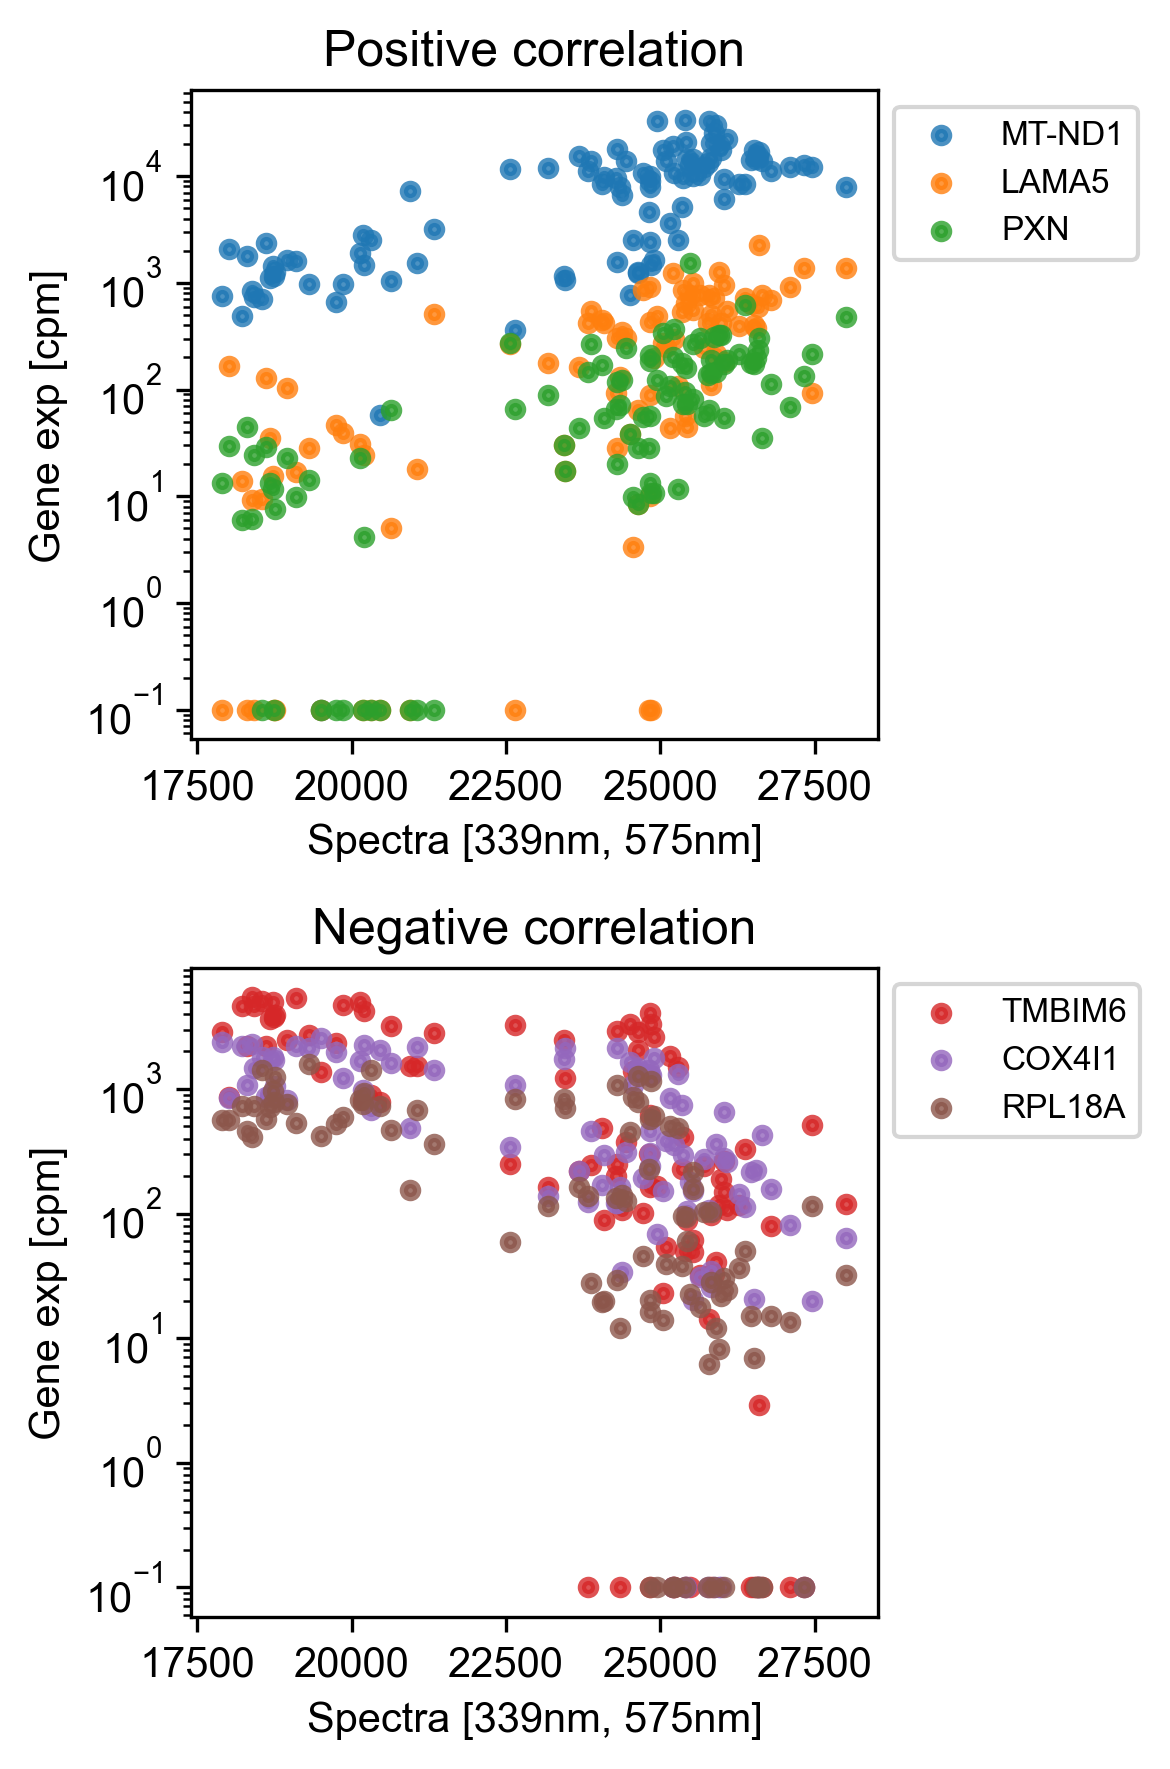

In [14]:
# scatter plots show top genes with positive or negative correlation coefficients among genes expressed by more
# than 80 % cells in each channel
feas = ['{}_{}'.format(col[0], col[1]) for col in df.columns]
xlabels = ['Spectra [{}nm, {}nm]'.format(fea.split('_')[0], fea.split('_')[1]) for fea in feas]

for fea, xlabel in zip(feas, xlabels):
    pos_genes = corr.loc[high_pct].nlargest(3, fea).index
    neg_genes = corr.loc[high_pct].nsmallest(3, fea).index

    path = save_figures
    filetype = '.png' 
    genes = {
        'positive': pos_genes,
        'negative': neg_genes,
    }
    plot_correlation(genes, adata, fea, xlabel, path, filetype='.pdf')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

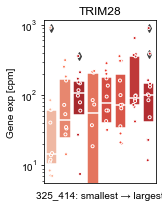

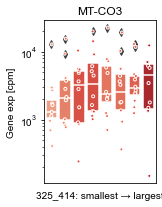

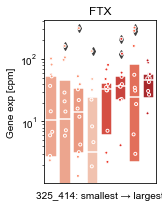

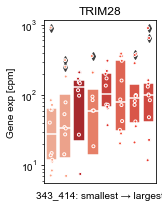

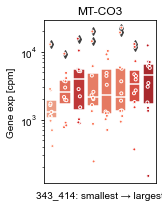

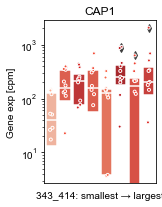

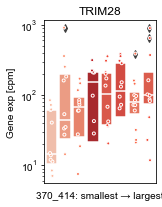

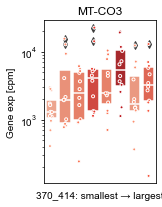

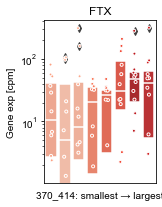

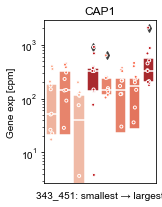

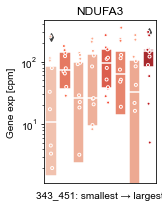

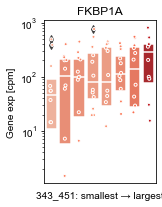

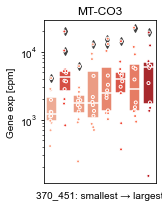

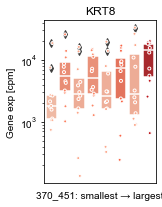

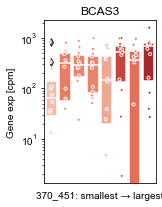

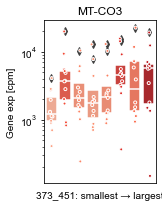

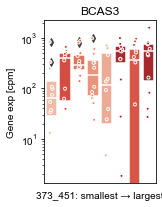

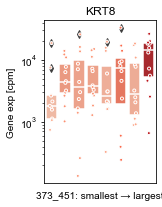

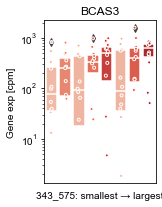

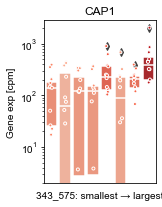

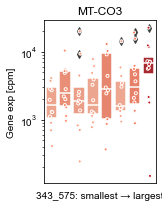

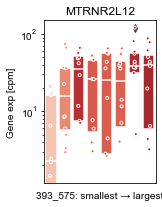

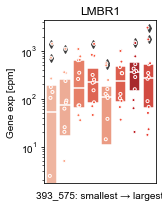

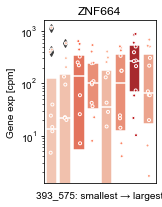

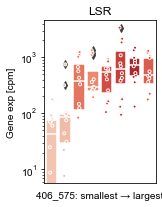

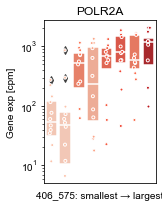

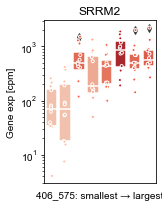

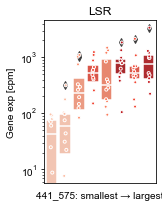

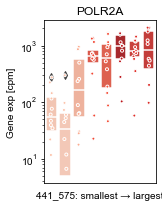

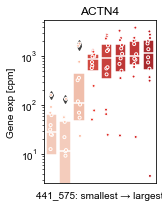

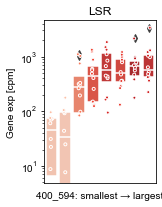

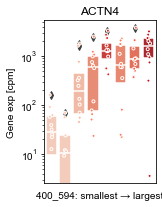

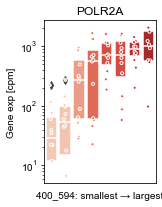

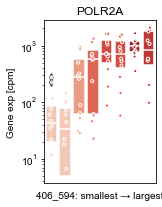

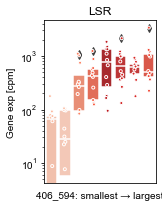

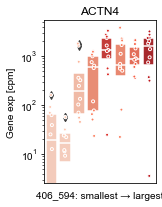

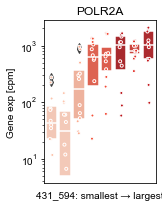

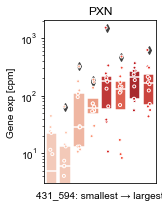

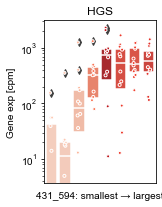

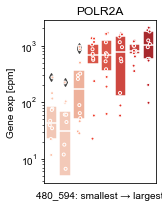

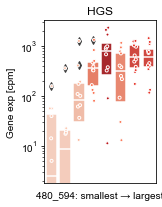

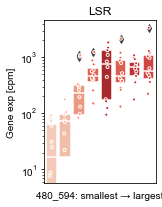

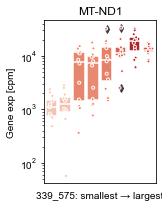

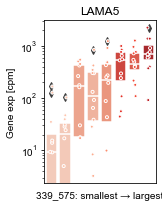

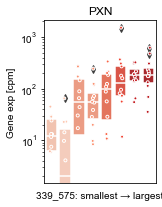

In [16]:
# plot top three genes with the highest positive correlation coefficients among genes expressed by more than
# 80 % cells in each channel
feas = ['{}_{}'.format(col[0], col[1]) for col in df.columns]

for fea in feas:
    pos = corr.loc[high_pct].nlargest(3, fea).index

    for gene in pos:
        cmap = 'Reds'
        bin_n = 8
        path = save_figures

        plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', path)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

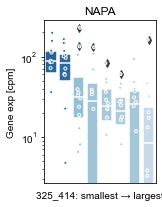

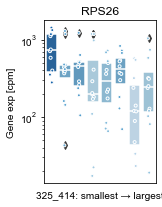

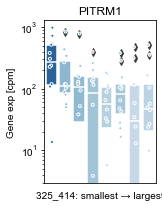

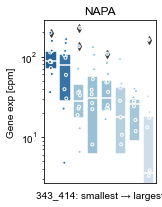

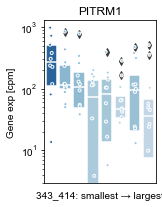

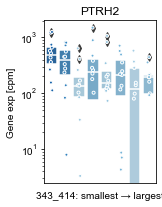

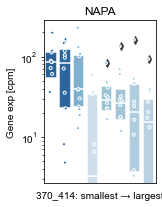

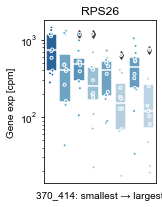

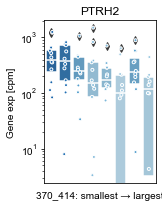

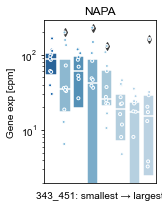

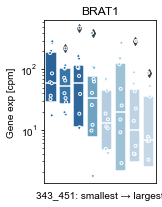

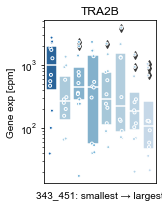

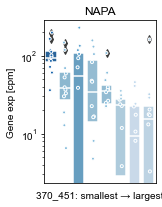

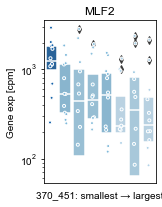

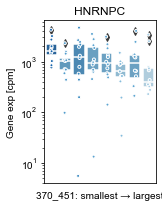

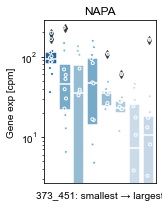

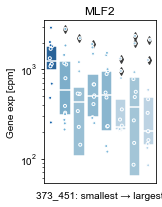

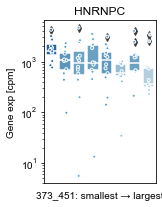

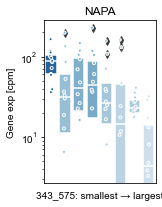

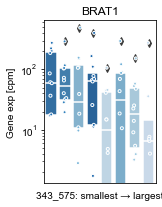

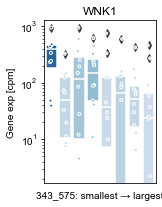

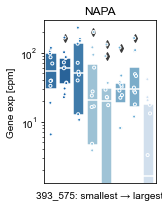

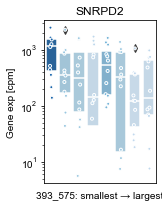

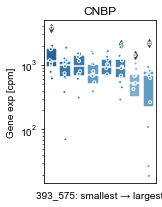

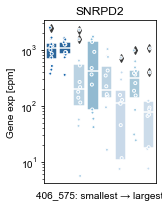

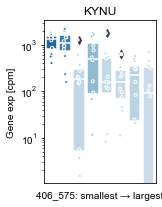

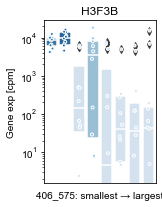

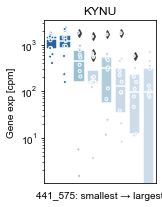

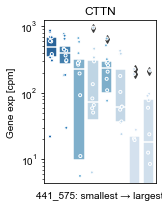

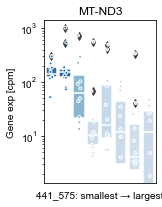

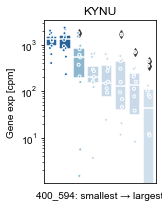

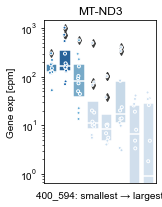

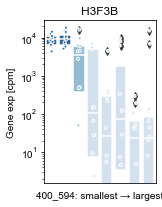

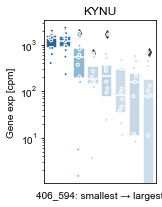

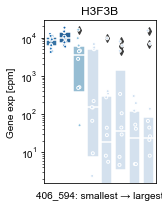

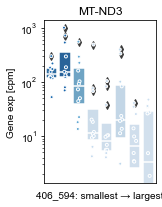

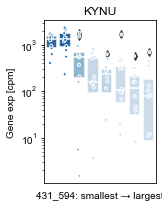

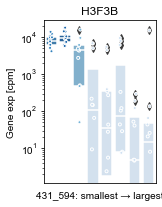

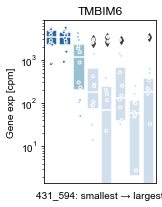

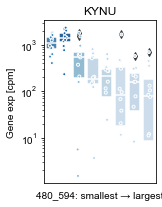

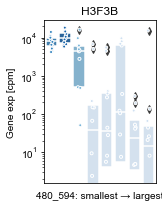

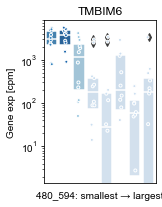

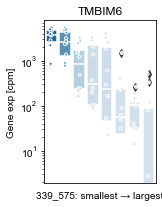

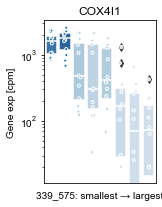

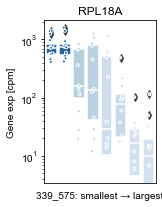

In [17]:
# plot top three genes with the highest negative correlation coefficients among genes expressed by more than
# 80 % cells in each channel
feas = ['{}_{}'.format(col[0], col[1]) for col in df.columns]

for fea in feas:
    negs = corr.loc[high_pct].nsmallest(3, fea).index

    for gene in negs:
        cmap = 'Blues'
        bin_n = 8
        path = save_figures

        plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', path)

## channel 343 451

In [5]:
corr = pd.read_csv(save_figures + 'spectra_gene_correlation.tsv', sep='\t', index_col=0)

<ipython-input-39-b8f08692678a>:108: RuntimeWarning: invalid value encountered in double_scalars
  alpha = [0.2 + 0.6 * i/max(med) for i in med]
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


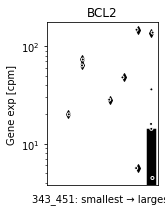

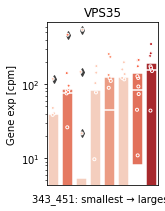

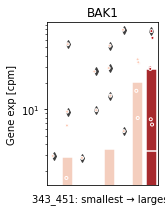

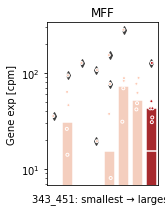

In [58]:
for gene in ['BCL2', 'VPS35', 'BAK1', 'MFF']:
    cmap = 'Reds'
    bin_n = 8
    path = save_figures

    plot_bins(adata, '343_451', bin_n, gene, cmap, '.pdf', path=save_figures + 'thesis/')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


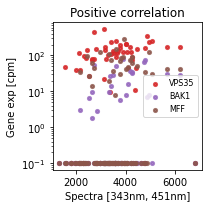

In [63]:
genes = ['VPS35', 'BAK1', 'MFF']
fig, ax = plt.subplots(figsize=[3, 3])
# rcParams['pdf.fonttype'] = 42
# rcParams['font.sans-serif'] = "Arial"
    
fea = '343_451'
xlabel = 'Spectra [343nm, 451nm]'
colors = sns.color_palette('tab10', 6)[3:]

for ig, gene in enumerate(genes):
    x = adata.obs[fea]
    y = adata[:, gene].X + 0.1
    idx = np.argsort(x)
    ax.scatter(
        x[idx], y[idx], alpha=0.8, label=gene, lw=2, color=colors[ig], s=10, 
    )
ax.legend(fontsize=8, loc='best')
ax.set_xlabel(xlabel)
ax.set_ylabel('Gene exp [cpm]')
ax.set_yscale('log')
#         ax.set_xscale('log')

ax.set_title('Positive correlation')
fig.tight_layout()
fig.savefig(save_figures + 'thesis/343_451_spectra2.pdf', dpi=150, bbox_inches='tight')

In [48]:
import gseapy as gp
from gseapy.plot import barplot

def gsea_analysis(genes, path, fn, title):
    res = gp.enrichr(gene_list=genes,
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway',
                     cutoff = 0.05)
    if fn is not False:
        res.res2d.to_csv(os.path.join(path, fn + '.tsv'), sep='\t')

    barplot(res.res2d, column='P-value', title=title, ofname=os.path.join(path, fn + '.svg')) 

In [49]:
gsea_analysis(pos_genes, save_figures, 'GSEAPY_C4_pos300', 'Pathways positively correlated with channel 4')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-03-09 12:39:29,740 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = 0.05


## channel 343 451

In [76]:
corr = pd.read_csv(save_figures + 'spectra_gene_correlation.tsv', sep='\t', index_col=0).fillna(0)

corr['Frac'] = 100 * (adata[:, corr.index].X > 0).sum(axis=0) / 95
corr['Number'] = (adata[:, corr.index].X > 0).sum(axis=0)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Text(0, 0.5, 'Cumulative over genes')

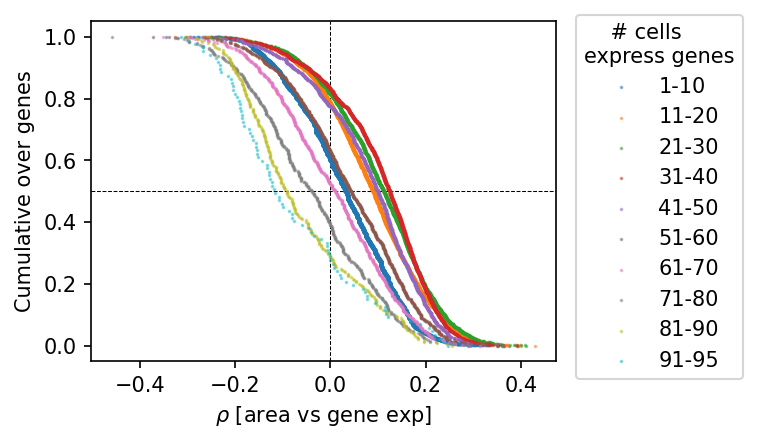

In [78]:
fea = '343_451'

fig, ax = plt.subplots(figsize=[4, 3], dpi=150)
for i in range(0, 10):
    n1 = 1 + i * 10
    if i < 9:
        n2 = n1 + 10
    else:
        n2 = 96
    
    Rs = corr[corr['Number'].isin(range(n1, n2))][fea].tolist()
    x = list(np.sort(Rs))
    y = list(1.0 - np.linspace(0, 1, len(Rs)))
    
#     x = [min(Rs)] + x
#     y = [0] + y
    
    ax.scatter(x, y, label='{}-{}'.format(str(n1), str(n2-1)), s=0.5, alpha=0.5)
ax.legend(title='    # cells\nexpress genes', bbox_to_anchor=(1.02, 1.05), loc='upper left')
ax.axvline(0, ls='--', c='k', zorder=-5, lw=0.5)
ax.axhline(0.5, ls='--', c='k', zorder=-5, lw=0.5)

ax.set_xlabel(r'$\rho$ [{} vs gene exp]'.format('area'))
ax.set_ylabel('Cumulative over genes')

[Text(0.5, 0, '# cells expressing the gene'),
 Text(0, 0.5, '$\\rho$ [343_451 vs gene exp]')]

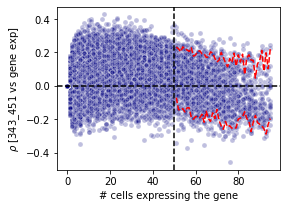

In [79]:
pa = '343_451'
threshold = 0.95
res = save_PC_frac_genes(corr, pa, 'Number', threshold)

fig, ax = plt.subplots(figsize=[4, 3])
ax.scatter(corr['Number'], corr[pa], color='navy', edgecolor='white', alpha=0.25, s=25)
ax.axhline(0, c='k', ls='--')
ax.axvline(50, c='k', ls='--')
ax.plot(res['Number'][51:], res['hmax'][51:], c='red', ls='--')
ax.plot(res['Number'][51:], res['hmin'][51:], c='red', ls='--')
ax.set(xlabel='# cells expressing the gene', ylabel=r'$\rho$ [{} vs gene exp]'.format(pa))

In [23]:
up_genes = []
down_genes = []

for _, row in res[51:].iterrows():
    up_genes += row['up_genes'].tolist()
    down_genes += row['down_genes'].tolist()
    
up_genes = np.unique(up_genes).tolist()
down_genes = np.unique(down_genes).tolist()

In [66]:
'''
COX6C:
The respiratory chain contains 3 multisubunit complexes succinate dehydrogenase (complex II, CII), 
ubiquinol-cytochrome c oxidoreductase (cytochrome b-c1 complex, complex III, CIII) and 
cytochrome c oxidase (complex IV, CIV), that cooperate to transfer electrons derived from 
NADH and succinate to molecular oxygen, creating an electrochemical gradient over the inner 
membrane that drives transmembrane transport and the ATP synthase. 
'''

# TTC19, COX6C, MT-CO3, NDUFA3

'\nCOX6C:\nThe respiratory chain contains 3 multisubunit complexes succinate dehydrogenase (complex II, CII), \nubiquinol-cytochrome c oxidoreductase (cytochrome b-c1 complex, complex III, CIII) and \ncytochrome c oxidase (complex IV, CIV), that cooperate to transfer electrons derived from \nNADH and succinate to molecular oxygen, creating an electrochemical gradient over the inner \nmembrane that drives transmembrane transport and the ATP synthase. \n'

In [65]:
corr[['343_451', 'Number']].loc[[gene for gene in up_genes if 'RPL' not in gene]].sort_values('343_451')[-30:]

343_451  Number
gene_name                  
FKBP1A     0.244895      82
LGALS8     0.245046      52
MT-CO3     0.246067      95
COX6C      0.247301      53
RPUSD3     0.248504      54
CYBA       0.248895      61
NDUFA3     0.250787      78
YWHAB      0.250980      69
BCAS3      0.254619      84
MYL12B     0.257265      62
TMOD3      0.259095      52
TFAP2C     0.260029      73
RBBP4      0.260674      61
SLC3A2     0.260684      60
RNF114     0.262135      68
RBM3       0.263916      60
SFPQ       0.273628      56
PLK2       0.276645      63
BUD31      0.277782      58
PDXK       0.280804      71
RPS9       0.282797      56
CAP1       0.289427      76
SUMO2      0.292593      55
TTC19      0.306262      54
GALNT6     0.312116      52
ABHD12     0.312790      58
ATG4B      0.314209      62
METRNL     0.319799      53
ID2        0.326911      51
RTN4       0.350252      51

In [74]:
corr[corr['Number'] > 70]['343_451'].sort_values()

gene_name
NAPA     -0.458383
BRAT1    -0.326199
RP9      -0.320420
TRA2B    -0.313106
WNK1     -0.307093
            ...   
NDUFA3    0.250787
BCAS3     0.254619
TFAP2C    0.260029
PDXK      0.280804
CAP1      0.289427
Name: 343_451, Length: 725, dtype: float64

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


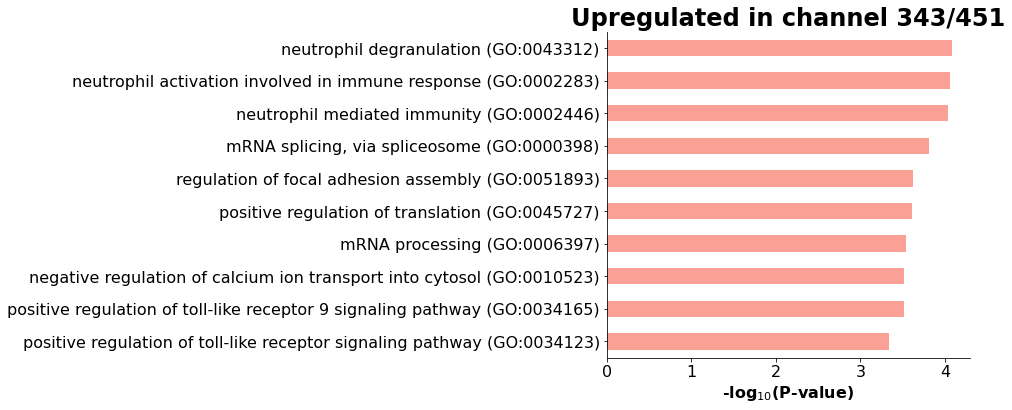

In [47]:
# import gseapy as gp
# from gseapy.plot import barplot

res1 = gp.enrichr(gene_list=[gene for gene in up_genes if 'RPL' not in gene],
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway',
                     cutoff = 0.05)

barplot(res1.res2d, column='P-value', title='Upregulated in channel 343/451', ofname=None) 

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


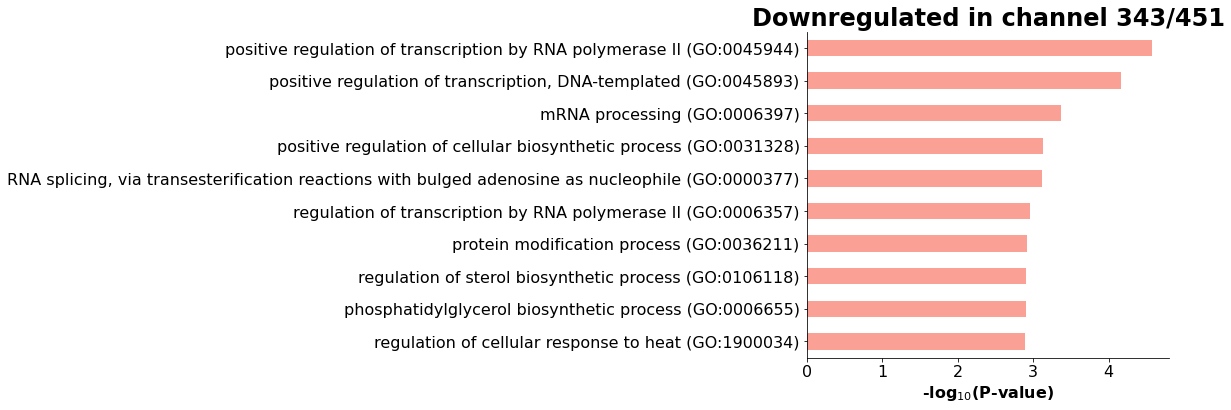

In [48]:
res2 = gp.enrichr(gene_list=[gene for gene in down_genes if 'RPL' not in gene],
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway',
                     cutoff = 0.05)

barplot(res2.res2d, column='P-value', title='Downregulated in channel 343/451', ofname=None) 

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

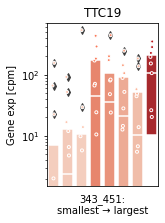

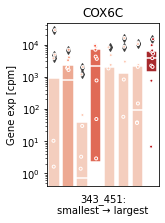

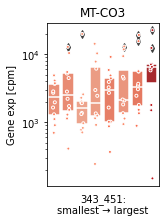

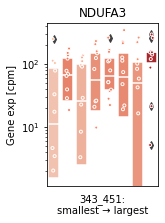

In [6]:
for gene in ['TTC19', 'COX6C', 'MT-CO3', 'NDUFA3']:
    cmap = 'Reds'
    bin_n = 8
    path = save_figures

    plot_bins(adata, '343_451', bin_n, gene, cmap, '.pdf', path=save_figures + 'paper/')